# 1. Initialization

This section contains code for initialization. It contains code from the labs relating to dataset preparation, setting up the experiments, and helper functions etc.



In [1]:
! pip install --quiet --upgrade "pip"
! pip install --quiet git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching torch torchvision matplotlib gdown tqdm ray=="2.6.3" seaborn torchmetrics

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.0 MB/s 

In [2]:
# Imports

import sys
import random
from collections.abc import Callable, Sequence
from copy import deepcopy
from pathlib import Path
from typing import Any
from logging import INFO
from datetime import timezone
from datetime import datetime

import flwr as fl
import gdown
import matplotlib.pyplot as plt
import numpy as np
import csv


import seaborn as sns
import pandas as pd
import torch
from torch import nn
import json
import torch.nn.functional as F
import torchvision
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.common.logger import log
from flwr.server import ServerConfig, History
from flwr.server.strategy import FedAvg, Strategy
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum
from flwr.client import Client


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf)


PathType = Path | str | None

The following contains code for preparing the dataset. This project uses CIFAR10 instead of FEMNIST and the code is changed accordingly.

In [3]:
home_dir = content if (content := Path("/content")).exists() else Path.cwd()
dataset_dir: Path = home_dir / "cifar10"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"

In [4]:
cifar10_train = torchvision.datasets.CIFAR10(dataset_dir, train = True, download = True)
cifar10_test = torchvision.datasets.CIFAR10(dataset_dir, train = False, download = True)

100%|██████████| 170498071/170498071 [00:10<00:00, 15821274.59it/s]


Extracting /content/cifar10/cifar-10-python.tar.gz to /content/cifar10
Files already downloaded and verified


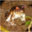

In [5]:
sample = next(iter(cifar10_train))
sample[0]

In [6]:
# Helper functions and experiment setup functions
def convert(o: Any) -> int | float:
    """Convert input object to Python numerical if numpy."""
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.int32 | np.int64):
        return int(o)
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.float32 | np.float64):
        return float(o)
    raise TypeError


def save_history(hist: History, name: str) -> None:
    """Save history from simulation to file."""
    time = int(datetime.now(timezone.utc).timestamp())
    path = home_dir / "histories"
    path.mkdir(exist_ok=True)
    path = path / f"hist_{time}_{name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)


def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap simulation to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    return parameter_list, hist

In [7]:
if not (home_dir / "common").exists():
    ! git clone "https://github.com/Tyv217/L361-Federated-Learning.git" temp_repo

    # Copy the folder to the current directory
    ! cp -r "temp_repo/labs/common" {home_dir}

    # Delete the cloned repository
    ! rm -rf temp_repo

    # Create the __init__.py file
    (home_dir / "__init__.py").open(mode="a+")

Cloning into 'temp_repo'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 371 (delta 143), reused 89 (delta 59), pack-reused 167
Receiving objects: 100% (371/371), 4.61 MiB | 7.84 MiB/s, done.
Resolving deltas: 100% (233/233), done.


In [8]:
from common.client_utils import (
    to_tensor_transform,
    get_model_parameters,
    set_model_parameters,
    get_federated_evaluation_function,
    aggregate_weighted_average,
    get_device,
)
from common.client import FlowerClient

# 2. Setup

Additional experimental setup functions. This includes code for partitioning (as CIFAR10 is not a FL dataset), the models we will be using, and code for setting up the FL experiments.

In [9]:
# Some variables

NUM_CLIENTS = 100
lda_concentrations = [0.1, 1.0, 1000.]
lda_concentration_string = ["0_1", "1", "1000"]

In [10]:
# Creating centralized partition
train_data_dir: Path = data_dir / "train"
test_data_dir: Path = data_dir / "test"
data_dir.mkdir(parents=True, exist_ok=True)
train_data_dir.mkdir(parents=True, exist_ok=True)
test_data_dir.mkdir(parents=True, exist_ok=True)

images_train, labels_train = zip(*cifar10_train)
for i, image in enumerate(images_train):
  image.save(f"{train_data_dir}/train_{i}.png")
image_train_paths = [f"train_{i}.png" for i, image in enumerate(images_train)]

images_test, labels_test = zip(*cifar10_test)
for i, image in enumerate(images_test):
  image.save(f"{test_data_dir}/test_{i}.png")
image_test_paths = [f"test_{i}.png" for i, image in enumerate(images_test)]

centralized_mapping.mkdir(parents=True, exist_ok=True)

train_path: Path = centralized_mapping / "train.csv"
test_path: Path = centralized_mapping / "test.csv"

pd.DataFrame(
    {
        "client_id": [0] * len(image_train_paths),
        "sample_path": image_train_paths,
        "sample_id": range(len(image_train_paths)),
        "label": labels_train,
    }
).to_csv(train_path, index=False, mode="w")
pd.DataFrame(
    {
        "client_id": [0] * len(image_test_paths),
        "sample_path": image_test_paths,
        "sample_id": range(len(image_test_paths)),
        "label": labels_test,
    }
).to_csv(test_path, index=False, mode="w")

In [11]:
# Creating federated partition using LDA

from common.lda_utils import create_lda_partitions

for i, concentration in enumerate(lda_concentrations):
  images_train, labels_train = zip(*cifar10_train)
  image_train_paths = np.array([f"train_{i}.png" for i, image in enumerate(images_train)])
  labels_train = np.array(labels_train)
  train_clients_partitions, dist = create_lda_partitions(
      dataset=(image_train_paths, labels_train),
      dirichlet_dist=None,
      num_partitions=NUM_CLIENTS,
      concentration=concentration,
      accept_imbalanced=True,
      seed=Seeds.DEFAULT,
  )
  images_test, labels_test = zip(*cifar10_test)
  image_test_paths = np.array([f"test_{i}.png" for i, image in enumerate(images_test)])

  lda_partition: Path = dataset_dir / "client_data_mappings" / "lda" / lda_concentration_string[i]
  if lda_partition.exists():
      ! rm -rf {str(lda_partition)}
  lda_partition.mkdir(parents=True, exist_ok=True)
  for j, (train_set) in enumerate(
      train_clients_partitions
  ):
      folder_path: Path = lda_partition / str(j)
      folder_path.mkdir(parents=True, exist_ok=True)

      train_path: Path = folder_path / "train.csv"
      test_path: Path = folder_path / "test.csv"

      pd.DataFrame(
          {
              "client_id": [0] * len(train_set[0]),
              "sample_path": train_set[0],
              "sample_id": range(len(train_set[0])),
              "label": train_set[1],
          }
      ).to_csv(train_path, index=False, mode="w")
      pd.DataFrame(
          {
              "client_id": [0] * len(image_test_paths),
              "sample_path": image_test_paths,
              "sample_id": range(len(image_test_paths)),
              "label": labels_test,
          }
      ).to_csv(test_path, index=False, mode="w")

In [12]:
from PIL import Image
from PIL.Image import Image as ImageType
class ImageDataset(Dataset):

    def __init__(
        self,
        mapping: Path,
        data_dir: Path,
        name: str = "train",
        transform: Callable[[ImageType], Any] | None = None,
        target_transform: Callable[[int], Any] | None = None,
    ) -> None:
        """
        Args:
            mapping (Path): path to the mapping folder containing the .csv files.
            data_dir (Path): path to the dataset folder. Defaults to data_dir.
            name (str): name of the dataset to load, train or test.
            transform (Optional[Callable[[ImageType], Any]], optional):
                    transform function to be applied to the ImageType object.
            target_transform (Optional[Callable[[int], Any]], optional):
                    transform function to be applied to the label.
        """
        self.data_dir = data_dir
        self.mapping = mapping
        self.name = name

        self.data: Sequence[tuple[str, int]] = self._load_dataset()
        self.transform: Callable[[ImageType], Any] | None = transform
        self.target_transform: Callable[[int], Any] | None = target_transform

    def __getitem__(self, index: int) -> tuple[Any, Any]:
        """Get a sample.

        Args:
            index (_type_): index of the sample.

        Returns
        -------
            Tuple[Any, Any]: couple (sample, label).
        """
        sample_path, label = self.data[index]

        # Convert to the full path
        full_sample_path: Path = self.data_dir / self.name / sample_path

        img: ImageType = Image.open(full_sample_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

    def __len__(self) -> int:
        """Get the length of the dataset as number of samples.

        Returns
        -------
            int: the length of the dataset.
        """
        return len(self.data)

    def _load_dataset(self) -> Sequence[tuple[str, int]]:
        """Load the paths and labels of the partition.

        Preprocess the dataset for faster future loading
        If opened for the first time

        Raises
        ------
            ValueError: raised if the mapping file doesn't exists

        Returns
        -------
            Sequence[Tuple[str, int]]:
                partition asked as a sequence of couples (path_to_file, label)
        """
        preprocessed_path: Path = (self.mapping / self.name).with_suffix(".pt")
        if preprocessed_path.exists():
            return torch.load(preprocessed_path)
        else:
            csv_path = (self.mapping / self.name).with_suffix(".csv")
            if not csv_path.exists():
                raise ValueError(f"Required files do not exist, path: {csv_path}")

            with open(csv_path) as csv_file:
                csv_reader = csv.reader(csv_file)
                # Ignore header
                next(csv_reader)

                # Extract the samples and the labels
                partition: Sequence[tuple[str, int]] = [
                    (sample_path, int(label_id))
                    for _, sample_path, _, label_id in csv_reader
                ]

                # Save for future loading
                torch.save(partition, preprocessed_path)
                return partition

def load_dataset(  # noqa: N802
    data_dir: Path, mapping: Path, name: str
) -> Dataset:
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return ImageDataset(
        mapping=mapping,
        name=name,
        data_dir=data_dir,
        transform=transform,
        target_transform=to_tensor_transform,
    )

We first define the models for training. These are simple CNNs and ViTs for CIFAR10.

In [13]:
class CIFAR10Net(nn.Module):

    def __init__(self, num_labels) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, num_labels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform a forward pass through the neural network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns
        -------
            torch.Tensor: The output tensor.
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_activations(self, x: torch.Tensor) -> dict:
        with torch.no_grad():
            activation1 = self.pool(F.relu(self.conv1(x)))
            activation2 = self.pool(F.relu(self.conv2(activation1)))
            activation3 = F.relu(self.conv3(activation2))
        return {"activation1": activation1.detach().cpu().numpy(), "activation2": activation2.detach().cpu().numpy(), "activation3": activation1.detach().cpu().numpy()}

In [14]:
from common.client import FlowerClient
from collections.abc import Sized
import logging

def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    data_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
    client_class = FlowerClient,
    *args,
    **kwargs,
) -> Callable[[str], FlowerClient]:

    def client_fn(cid: str) -> FlowerClient:
        return client_class(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
            data_dir=data_dir,
            *args,
            **kwargs,
        )

    return client_fn

def get_federated_evaluation_function(
    data_dir: Path,
    centralized_mapping: Path,
    device: str,
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
) -> Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
    """Wrap function for the external federated evaluation function.

    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Args:
        data_dir (Path): path to the dataset folder.
        centralized_mapping (Path): path to the mapping .csv file chosen.
        device (str):  device name onto which perform the computation.
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion.

    Returns
    -------
        Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
            external federated evaluation function.
    """
    full_file: Path = centralized_mapping
    dataset: Dataset = load_dataset(data_dir, full_file, "test")
    num_samples = len(cast(Sized, dataset))
    index_list = list(range(num_samples))
    prng = np.random.RandomState(1337)
    prng.shuffle(index_list)
    index_list = index_list[:1500]
    dataset = torch.utils.data.Subset(dataset, index_list)

    log(
        logging.INFO,
        "Reduced federated test_set size from %s to a size of %s mean index: %s",
        num_samples,
        len(cast(Sized, dataset)),
        np.mean(index_list),
    )

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> tuple[float, dict[str, Scalar]]:
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        test_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test(
            net=net,
            test_loader=test_loader,
            device=device,
            criterion=criterion,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function

In [15]:
def get_network_generator_cnn():
    untrained_net: CIFAR10Net = CIFAR10Net(num_labels = 10)
    def generated_net():
        return deepcopy(untrained_net)
    return generated_net

def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf)

In [16]:
# Plot train loss and accuracy

import matplotlib.pyplot as plt
def plot_metric(history, m, name, distributed = True):
  if distributed:
    metrics = history.metrics_distributed_fit
    metric = metrics[m]
    plot_x = [0]
    plot_y = [0.]
    for round in range(len(metric)):
      avg = 0.
      count = 0
      for i in metric[round][1]['all']:
        avg += i[1]
        count += 1
      avg /= count
      plot_x.append(round + 1)
      plot_y.append(avg)
    print()
    print(name + "_" + m + ": ", plot_y)
    plt.plot(plot_x, plot_y, label = name)
  else:
    metrics = history.metrics_centralized
    metric = metrics[m]
    x, y = zip(*metric)
    print(name + "_" + m + ": ", y)
    plt.plot(x, y, label = name)

# 3. Experiments

The following contains code to be running the experiments. This is split into the basic requirements, and the extensions part. The basic requirements looks into FedOpt and how the different FedOpt strategies perform under different data heterogeneity levels.

In order to save computing resources and focus more on per-round effects in FL, in this project we use models trained with 50% of steps necessary for full training as the starting model in FL experiments. To determine the number of steps necessary for full training, we train a centralized model until its performance stops improving. The following is a simple FlowerClient which performs validation during training and stops training when the performance on the validation dataset stops improving. For our experiment purposes, since FedAvg and FedOpt all use SGD as the client local optimizer, we also use SGD in this experiment.

In [17]:
from typing import cast
from torchmetrics.classification import Accuracy

def test(  # noqa: N802
    net: Module,
    test_loader: DataLoader,
    device: str,
    criterion: Module,
    max_batches: int | None = None,
    **kwargs: dict[str, Any],
) -> tuple[float, float]:
    batch_cnt = 0
    correct, total, loss = 0, 0, 0.0
    net.eval()

    with torch.no_grad():
        for data, labels in tqdm(test_loader):

            if max_batches is not None and batch_cnt >= max_batches:
                break
            batch_cnt += 1

            data, labels = data.to(device), labels.to(device)
            outputs = net(data)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return loss, accuracy


class FlowerEarlyStoppingClient(FlowerClient):
  def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
        data_dir: Path,
        validation_config: dict
    ):
    self.cid = cid
    log(INFO, "Creating client with cid: %s", self.cid)
    self.partition_dir = partition_dir
    self.data_dir = data_dir
    self.device = get_device()
    self.model_generator: Callable[[], Module] = model_generator
    self.properties: dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}
    self.validation_config = validation_config
    self.epochs_trained = 0

  def fit(
      self, parameters: NDArrays, config: dict[str, Scalar]
  ) -> tuple[NDArrays, int, dict]:
      """Receive and train a model on the local client data.

      It uses the instruction passed through the config dict.

      Args:
          net (NDArrays): Pytorch model parameters
          config (dict[str, Scalar]): dictionary describing the training parameters

      Returns
      -------
          tuple[NDArrays, int, dict]: Returns the updated model, the size of the local
              dataset and other metrics
      """
      # Only create model right before training/testing
      # To lower memory usage when idle
      net = self.set_parameters(parameters)
      net.to(self.device)

      train_loader: DataLoader = self._create_data_loader(config, name="train")
      train_loss, validation_metrics = self._train(net, train_loader=train_loader, config=config)
      return get_model_parameters(net), len(train_loader), {"train_loss": train_loss, "validation_metrics": validation_metrics}

  def _train(
        self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
    ) -> float:
      running_loss, total = 0.0, 0
      min_validation_loss = float('inf')
      early_stopping_counter = 0
      if(config["optimizer"] == "sgd"):
        optimizer = torch.optim.SGD(
            net.parameters(),
            lr = float(config["client_learning_rate"]),
            weight_decay=float(config["weight_decay"])
        )
      elif(config["optimizer"] == "adam"):
        optimizer=torch.optim.AdamW(
            net.parameters(),
            lr=float(config["client_learning_rate"]),
            weight_decay=float(config["weight_decay"])
        )
      criterion=torch.nn.CrossEntropyLoss()
      max_batches=cast(int | None, config["max_batches"])
      self.accuracy = Accuracy(task = "multiclass", num_classes = 10).to(self.device)
      validation_accuracies = []
      validation_losses = []
      for epoch in tqdm(range(int(config["epochs"]))):
          net.train()
          running_loss = 0.0
          total, batch_cnt = 0, 0
          train_size = int(self.validation_config["train_dataloader_ratio"] * len(train_loader.dataset))
          valid_size = len(train_loader.dataset) - train_size
          train_dataset, valid_dataset = torch.utils.data.random_split(train_loader.dataset, [train_size, valid_size])
          train_dataloader = DataLoader(train_dataset, batch_size=train_loader.batch_size, shuffle=True)
          valid_dataloader = DataLoader(valid_dataset, batch_size=train_loader.batch_size, shuffle=False)
          for i, (data, labels) in enumerate(train_dataloader):
              data, labels = data.to(self.device), labels.to(self.device)
              optimizer.zero_grad()
              outputs = net(data)
              loss = criterion(outputs, labels)
              running_loss += loss.item()
              total += labels.size(0)
              loss.backward()
              optimizer.step()

              # Break if we have exceeded the upper limit
              # On training batches for a given round
              # Simulate enumerate counting for train/test parity
              if max_batches and batch_cnt > max_batches:
                  break
              batch_cnt += 1
          self.epochs_trained += 1
          net.eval()
          validation_loss = 0.
          validation_accuracy = []
          for i, (data, labels) in enumerate(valid_dataloader):
                data, labels = data.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = net(data)
                loss = criterion(outputs, labels)
                validation_accuracy.append(self.accuracy(outputs, labels).detach().cpu().numpy())
                running_loss += loss.item()
                validation_loss += loss.item()
                total += labels.size(0)
          validation_losses.append(validation_loss)
          validation_accuracies.append(np.mean(validation_accuracy))
          if (validation_loss - min_validation_loss) < self.validation_config["min_delta"]:
            min_validation_loss = min(validation_loss, min_validation_loss)
            early_stopping_counter = 0
          else:
            min_validation_loss = min(validation_loss, min_validation_loss)
            early_stopping_counter += 1
            if(early_stopping_counter > self.validation_config["patience"]):
              break

      return running_loss / total, [validation_accuracies, validation_losses]
  def _load_dataset(self, name: str) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_dataset(
            mapping=full_file,
            name=name,
            data_dir=self.data_dir,
        )

In [18]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()

centralized_early_stopping_flower_client_generator: Callable[
    [int], FlowerClient
] = get_flower_client_generator(
    model_generator=network_generator_cnn,
    partition_dir=centralized_partition,
    data_dir=data_dir,
    client_class=FlowerEarlyStoppingClient,
    validation_config = {
        "min_delta": 0,
        "patience": 5,
        "train_dataloader_ratio": 0.95
    }
)
centralized_train_config: dict[str, Any] = {
    "epochs": 100,
    "batch_size": 1024,
    "optimizer": "adam",
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "max_batches": None,
    "num_workers": 0
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": None
}

federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss()
)

centralized_early_stopping_flower_client = centralized_early_stopping_flower_client_generator(0)
seed_net_cnn = network_generator_cnn()
randomly_seeded_parameters = get_model_parameters(seed_net_cnn)

INFO flwr 2024-03-20 11:17:32,518 | <ipython-input-14-ee17c45357c9>:65 | Reduced federated test_set size from 10000 to a size of 1500 mean index: 4924.406
INFO:flwr:Reduced federated test_set size from 10000 to a size of 1500 mean index: 4924.406
INFO flwr 2024-03-20 11:17:32,523 | <ipython-input-17-7c50ef186678>:45 | Creating client with cid: 0
INFO:flwr:Creating client with cid: 0


In [19]:
RERUN_CENTRALIZED_FLOWER_TEST = False

if RERUN_CENTRALIZED_FLOWER_TEST:

  trained_params, num_examples, train_metrics = fit_client_seeded(
      centralized_early_stopping_flower_client,
      params=randomly_seeded_parameters,
      conf=centralized_train_config,
  )

  loss, num_examples, test_metrics_centralized_training = centralized_early_stopping_flower_client.evaluate(
      parameters=trained_params, config=test_config
  )

  validation_accuracies = train_metrics['validation_metrics'][0]
  validation_losses = train_metrics['validation_metrics'][1]

  print(
      f"\nFinal Validation accuracy: {validation_accuracies[-1]}"
      f"\nFinal validation loss: {validation_losses[-1]}"
      f"\nTest accuracy: {test_metrics_centralized_training['local_accuracy']}"
  )


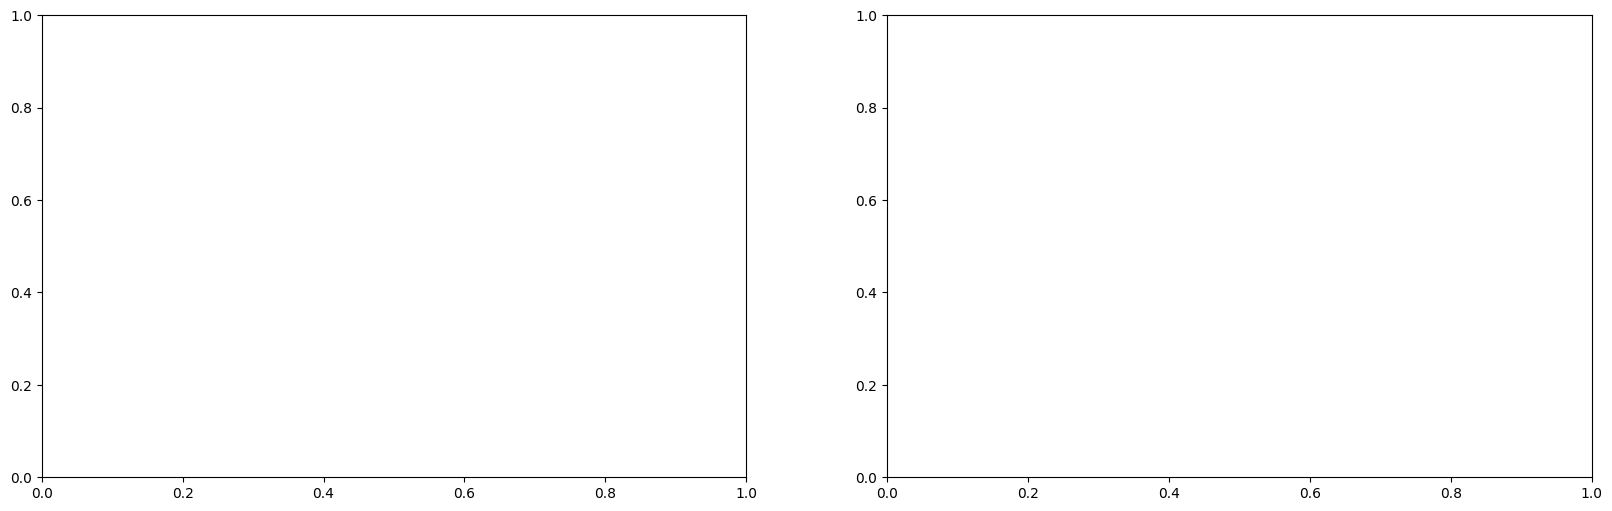

In [20]:
import matplotlib.pyplot as plt
try:
  plt.figure(figsize=(20,6))
  ax1 = plt.subplot(1, 2, 1)
  ax2 = plt.subplot(1, 2, 2)

  # ax1.plot([0] + validation_accuracies, np.arange(len(validation_accuracies) + 1))
  ax1.plot(np.arange(len(validation_accuracies) + 1), [0] + validation_accuracies)
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Validation accuracy")
  ax1.set_title("Validation accuracy over time")
  ax2.plot(np.arange(len(validation_losses)), validation_losses)
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Validation losses")
  ax2.set_title("Validation losses over time")
  plt.show()
except:
  pass

In [21]:
epochs_trained = centralized_early_stopping_flower_client.epochs_trained
print(centralized_early_stopping_flower_client.epochs_trained)
if epochs_trained == 0:
  # Avoid rerunning experiments
  epochs_trained = 43

0


In [22]:
centralized_partially_train_config: dict[str, Any] = {
    "epochs": epochs_trained / 2,
    "batch_size": 1024,
    "optimizer": "adam",
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "max_batches": None,
    "num_workers": 0
}
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss()
)

centralized_early_stopping_flower_client = centralized_early_stopping_flower_client_generator(0)
seed_net_cnn = network_generator_cnn()
randomly_seeded_parameters = get_model_parameters(seed_net_cnn)

load_half_trained_params = True

if not load_half_trained_params:
  half_trained_params, num_examples, train_metrics = fit_client_seeded(
      centralized_early_stopping_flower_client,
      params=randomly_seeded_parameters,
      conf=centralized_partially_train_config,
  )
  np.savez("half_trained_params.npz", *half_trained_params)

else:
  with np.load("common/data/half_trained_params.npz") as filez:
    half_trained_params = [filez[name] for name in filez.files]

INFO flwr 2024-03-20 11:17:32,959 | <ipython-input-14-ee17c45357c9>:65 | Reduced federated test_set size from 10000 to a size of 1500 mean index: 4924.406
INFO:flwr:Reduced federated test_set size from 10000 to a size of 1500 mean index: 4924.406
INFO flwr 2024-03-20 11:17:32,963 | <ipython-input-17-7c50ef186678>:45 | Creating client with cid: 0
INFO:flwr:Creating client with cid: 0


Now that we have obtained our half-trained model, we can perform Federated Learning experiments on them. This includes the following experiments.

1. Obtaining test accuracy on a centralized test set.
2. Inspect activations given a randomly sampled input from a uniform distribution.
3. Inspect activations on centralized test set, in each round compare client activations against each other as well as global model (previous round and next round).

All of these experiments will be run on centralized training with the entire dataset as well as Federated Learning with different degrees of LDA concentrations and using different aggregation strategies (FedAvg vs different variations of FedOpt). This will give us an in-depth understanding of the the learned clients and global models in FL, and how they differ under different LDA concentrations (different degrees of i.i.d.-ness) and different aggregation strategies.

To avoid having to rerun experiments I will adapt the client functions to obtain their activations on the centralized test set. These activations will be the output of each of the convolution blocks (pooling + ReLU + convolution layers).

Firstly, some auxiliary functions to run FL simulations:

In [23]:
def save_history(hist: History, name: str):
    time = int(datetime.now(timezone.utc).timestamp())
    path = home_dir / "histories"
    path.mkdir(exist_ok=True)
    path = path / f"hist_{time}_{name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)


def start_seeded_simulation(
    client_fn: Callable[[int], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrapper to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    return parameter_list, hist

In [24]:
from typing import cast

class FlowerSaveActivationClient(FlowerClient):
  def __init__(
        self,
        cid: int,
        partition_dir: Path,
        save_activation_dir: Path,
        model_generator: Callable[[], Module],
        data_dir: Path,
        save_activation_rounds: list = []
    ):
    self.cid = cid
    log(INFO, "Creating client with cid: %s", self.cid)
    self.partition_dir = partition_dir
    self.data_dir = data_dir
    self.save_activation_dir = save_activation_dir
    self.save_activation_rounds = save_activation_rounds
    self.device = get_device()
    self.model_generator: Callable[[], Module] = model_generator
    self.properties: dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

  def fit(
      self, parameters: NDArrays, config: dict[str, Scalar]
  ) -> tuple[NDArrays, int, dict]:
      """Receive and train a model on the local client data.

      It uses the instruction passed through the config dict.

      Args:
          net (NDArrays): Pytorch model parameters
          config (dict[str, Scalar]): dictionary describing the training parameters

      Returns
      -------
          tuple[NDArrays, int, dict]: Returns the updated model, the size of the local
              dataset and other metrics
      """
      # Only create model right before training/testing
      # To lower memory usage when idle
      net = self.set_parameters(parameters)
      net.to(self.device)

      train_loader: DataLoader = self._create_data_loader(config, name="train")
      train_loss = self._train(net, train_loader=train_loader, config=config)
      curr_round = config["server_round"]
      if curr_round in self.save_activation_rounds:
        save_dir: Path = self.save_activation_dir / str(curr_round)
        save_dir.mkdir(parents=True, exist_ok=True)
        test_loader: DataLoader = self._create_data_loader(config, name="test")
        test_activations = self._get_test_activations(net, test_loader=test_loader, config=config)
        for key, val in test_activations.items():
          np.save(f"{save_dir}/{key}_{self.cid}.npy", val)

      return get_model_parameters(net), len(train_loader), {"train_loss": train_loss}

  def _train(
        self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
    ) -> float:
      running_loss, total = 0.0, 0
      if(config["optimizer"] == "sgd"):
        optimizer = torch.optim.SGD(
            net.parameters(),
            lr = float(config["client_learning_rate"]),
            weight_decay=float(config["weight_decay"])
        )
      elif(config["optimizer"] == "adam"):
        optimizer=torch.optim.AdamW(
            net.parameters(),
            lr=float(config["client_learning_rate"]),
            weight_decay=float(config["weight_decay"])
        )
      criterion=torch.nn.CrossEntropyLoss()
      max_batches=cast(int | None, config["max_batches"])
      for epoch in tqdm(range(int(config["epochs"]))):
          net.train()
          running_loss = 0.0
          total, batch_cnt = 0, 0
          for i, (data, labels) in enumerate(train_loader):
              data, labels = data.to(self.device), labels.to(self.device)
              optimizer.zero_grad()
              outputs = net(data)
              loss = criterion(outputs, labels)
              running_loss += loss.item()
              total += labels.size(0)
              loss.backward()
              optimizer.step()

              # Break if we have exceeded the upper limit
              # On training batches for a given round
              # Simulate enumerate counting for train/test parity
              if max_batches and batch_cnt > max_batches:
                  break
              batch_cnt += 1
      return running_loss / total

  def _get_test_activations(self, net: Module, test_loader: DataLoader, config: dict[str, Scalar]
    ) -> dict:
      activations_dict = {}
      for i, (data, labels) in enumerate(test_loader):
        data = data.to(self.device)
        activations = net.get_activations(data)
        for key in activations.keys():
          if key in activations_dict.keys():
            activations_dict[key] = np.append(activations_dict[key],activations[key], axis = 0)
          else:
            activations_dict[key] = activations[key]
      return activations_dict

  def _load_dataset(self, name: str) -> Dataset:
      full_file: Path = self.partition_dir / str(self.cid)
      return load_dataset(
          mapping=full_file,
          name=name,
          data_dir=self.data_dir,
      )

We want to first focus on single-round effects (or a small number of rounds).

In [37]:
from common.client_utils import aggregate_weighted_average

lda_concentrations = [0.1, 1., 1000.]
lda_concentration_string = ["0_1", "1", "1000"]

torch.manual_seed(Seeds.DEFAULT)
num_rounds: int = 10
num_total_clients: int = 100
num_clients_per_round: int = 10
num_evaluate_clients: int = 1

train_config: dict[str, Any] = {
    "epochs": 8,
    "batch_size": 128,
    "optimizer": "sgd",
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": None,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
}

def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config | {"server_round": server_round}


def _on_evaluate_config_fn(server_round: int) -> dict[str, Scalar]:
    return test_config | {"server_round": server_round}

fraction_fit = sys.float_info.min
fraction_evaluate = sys.float_info.min
accept_failures = True
min_fit_clients = num_clients_per_round
min_available_clients = max(num_clients_per_round, num_evaluate_clients)
initial_parameters: Parameters = ndarrays_to_parameters(half_trained_params)
# initial_parameters: Parameters = ndarrays_to_parameters(randomly_seeded_parameters)
# randomly_seeded_parameters

fed_eval: bool = True

fedavg = FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    evaluate_fn=(
            federated_evaluation_function if fed_eval else None
        ),
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [38]:
from flwr.server import SimpleClientManager, Server, ServerConfig

save_activation = True
save_activation_dir: Path = home_dir / "activation_data"

save_activation_dir.mkdir(parents=True, exist_ok=True)

save_activation_rounds = []

i = 2
lda_partition: Path = dataset_dir / "client_data_mappings" / "lda" / lda_concentration_string[i]
lda_activation_data: Path = save_activation_dir / lda_concentration_string[i]
federated_save_activation_flower_client_generator: Callable[
    [int], FlowerClient
] = get_flower_client_generator(
    model_generator=network_generator_cnn,
    partition_dir=lda_partition,
    data_dir=data_dir,
    client_class=FlowerSaveActivationClient,
    save_activation_dir = lda_activation_data,
    save_activation_rounds = save_activation_rounds
)
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss()
)

INFO flwr 2024-03-20 14:06:20,231 | <ipython-input-14-ee17c45357c9>:65 | Reduced federated test_set size from 10000 to a size of 1500 mean index: 4924.406
INFO:flwr:Reduced federated test_set size from 10000 to a size of 1500 mean index: 4924.406


In [40]:
# Search through hyperparameter values
ten_round_hist_fedavg = {}
ten_round_hist_fedavg[lda_concentration_string[i]] = []
for learning_rate in [0.01, 4e-3, 1e-3, 4e-4]:

  train_config["epochs"] = 8
  train_config["client_learning_rate"] = learning_rate
  def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
      return train_config | {"server_round": server_round}
  fedavg = FedAvg(
      fraction_fit=fraction_fit,
      fraction_evaluate=fraction_evaluate,
      min_fit_clients=min_fit_clients,
      min_available_clients=min_available_clients,
      on_fit_config_fn=_on_fit_config_fn,
      on_evaluate_config_fn=_on_evaluate_config_fn,
      initial_parameters=initial_parameters,
      accept_failures=accept_failures,
      evaluate_fn=(
              federated_evaluation_function if fed_eval else None
          ),
      fit_metrics_aggregation_fn=aggregate_weighted_average,
      evaluate_metrics_aggregation_fn=aggregate_weighted_average,
  )
  params, hist = start_seeded_simulation(
      client_fn=lambda cid: federated_save_activation_flower_client_generator(cid).to_client(),
      num_clients=num_total_clients,
      config=ServerConfig(num_rounds=num_rounds),
      strategy=fedavg,
      name=f"fedavg_lda_{lda_concentration_string[i]}",
  )
  ten_round_hist_fedavg[lda_concentration_string[i]].append([learning_rate, 8, hist])

Streaming output truncated to the last 5000 lines.
 88%|████████▊ | 7/8 [00:35<00:05,  5.04s/it]



100%|██████████| 8/8 [00:38<00:00,  4.81s/it]
INFO flwr 2024-03-20 14:31:24,108 | <ipython-input-24-26dde4563a2a>:14 | Creating client with cid: 40
INFO:flwr:Creating client with cid: 40
  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:40<00:00,  5.53s/it]


100%|██████████| 8/8 [00:41<00:00,  5.13s/it]
INFO flwr 2024-03-20 14:31:26,228 | <ipython-input-24-26dde4563a2a>:14 | Creating client with cid: 10
INFO:flwr:Creating client with cid: 10
INFO flwr 2024-03-20 14:31:26,229 | <ipython-input-24-26dde4563a2a>:14 | Creating client with cid: 24
INFO:flwr:Creating client with cid: 24


  0%|          | 0/8 [00:00<?, ?it/s]


  0%|          | 0/8 [00:00<?, ?it/s]




100%|██████████| 8/8 [00:40<00:00,  5.10s/it]
INFO flwr 2024-03-20 14:31:27,409 | <ipython-input-24-26dde4563a2a>:14 | Creating client with cid: 56
INFO:flwr:Creating client with cid: 56





  0%|          | 0/8 [

In [41]:
ten_round_hist_fedavg

{'1000': [[0.01,
   8,
   History (loss, centralized):
   	round 0: 55.79068315029144
   	round 1: 60.68361538648605
   	round 2: 55.26560229063034
   	round 3: 58.853963136672974
   	round 4: 55.99845939874649
   	round 5: 56.191674649715424
   	round 6: 55.925880908966064
   	round 7: 55.23924618959427
   	round 8: 57.41090101003647
   	round 9: 59.544851422309875
   	round 10: 57.1943519115448
   History (metrics, distributed, fit):
   {'train_loss': [(1, {'avg': 0.008860125322826207, 'all': [(3, 0.011280142702162266), (3, 0.006087392879029115), (3, 0.007312256221969922), (3, 0.007639526389539242), (3, 0.010434483177959919), (3, 0.010164807550609112), (3, 0.012896360519031683), (3, 0.00486914402184387), (3, 0.007406521588563919), (3, 0.010510618177553019)]}), (2, {'avg': 0.0072785117042561374, 'all': [(3, 0.00700260978192091), (3, 0.006434827422102292), (3, 0.007102165992061297), (3, 0.006787802403171857), (3, 0.00608433922752738), (3, 0.0076137132321794825), (3, 0.01003566104918718

lr=0.01_epochs=8_accuracy:  (0.6046666666666667, 0.568, 0.6133333333333333, 0.5806666666666667, 0.6113333333333333, 0.61, 0.61, 0.618, 0.5966666666666667, 0.5906666666666667, 0.5973333333333334)
lr=0.004_epochs=8_accuracy:  (0.6046666666666667, 0.6166666666666667, 0.6146666666666667, 0.6173333333333333, 0.618, 0.6146666666666667, 0.6106666666666667, 0.62, 0.6133333333333333, 0.6146666666666667, 0.61)
lr=0.001_epochs=8_accuracy:  (0.6046666666666667, 0.6133333333333333, 0.616, 0.616, 0.6126666666666667, 0.616, 0.61, 0.6186666666666667, 0.62, 0.6206666666666667, 0.62)
lr=0.0004_epochs=8_accuracy:  (0.6046666666666667, 0.6086666666666667, 0.6113333333333333, 0.6146666666666667, 0.6113333333333333, 0.614, 0.6106666666666667, 0.6133333333333333, 0.616, 0.614, 0.6173333333333333)


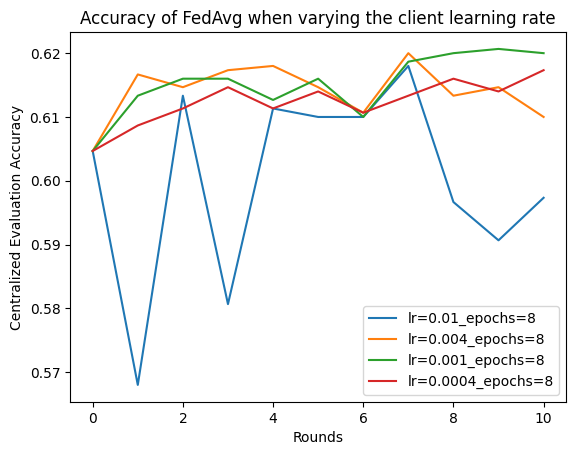

In [42]:
for key in ten_round_hist_fedavg.keys():
  all_hist = ten_round_hist_fedavg[key]
  for hist_fedavg in all_hist:
    lr = hist_fedavg[0]
    local_epochs = hist_fedavg[1]
    history = hist_fedavg[2]
    plot_metric(history, "accuracy", "lr=" + str(lr) + "_epochs=" + str(local_epochs), distributed = False)

# mp = {}

# mp[0.01] = [(0, 0.6046666666666667), (1, 0.5866666666666667), (2, 0.594), (3, 0.5766666666666667), (4, 0.5526666666666666), (5, 0.5946666666666667), (6, 0.6053333333333333), (7, 0.5686666666666667), (8, 0.59), (9, 0.594), (10, 0.62)]
# mp[0.004] = [(0, 0.6046666666666667), (1, 0.6153333333333333), (2, 0.6053333333333333), (3, 0.59), (4, 0.6126666666666667), (5, 0.6093333333333333), (6, 0.61), (7, 0.6006666666666667), (8, 0.5873333333333334), (9, 0.6066666666666667), (10, 0.612)]
# mp[0.001] = [(0, 0.6046666666666667), (1, 0.612), (2, 0.6126666666666667), (3, 0.608), (4, 0.622), (5, 0.6073333333333333), (6, 0.6186666666666667), (7, 0.6113333333333333), (8, 0.598), (9, 0.6113333333333333), (10, 0.6213333333333333)]
# mp[0.0004] = [(0, 0.6046666666666667), (1, 0.6133333333333333), (2, 0.614), (3, 0.612), (4, 0.6173333333333333), (5, 0.61), (6, 0.614), (7, 0.61), (8, 0.61), (9, 0.612), (10, 0.622)]

# for key, val in mp.items():
#     x1, y1 = zip(*val)
#     plt.plot(x1, y1, label = "lr=" + str(key) + "_epochs=" + str(8))
#     print("lr=" + str(key) + "_epochs=" + str(8) + "_accuracy: ", y1)

plt.title("Accuracy of FedAvg when varying the client learning rate")
plt.xlabel("Rounds")
plt.ylabel("Centralized Evaluation Accuracy")
plt.legend()
plt.show()


lr=0.01_epochs=8_train_loss:  [0.0, 0.008860125322826205, 0.007278511704256137, 0.007053011966248353, 0.006439923386399944, 0.00642750293482095, 0.007342116922761004, 0.006560662481933832, 0.006667327058191101, 0.006456490186974406, 0.006420003638292352]

lr=0.004_epochs=8_train_loss:  [0.0, 0.005734816597153744, 0.006073382807274661, 0.006047219798589746, 0.006154774393265445, 0.005695465936635931, 0.006112250437339147, 0.005644155394596359, 0.0056359069809938465, 0.005591433898856243, 0.005792162769163648]

lr=0.001_epochs=8_train_loss:  [0.0, 0.005618357860172788, 0.005628189692894617, 0.005642508746435245, 0.0055612148639435565, 0.005442597228102385, 0.005706522163624566, 0.005580887974550326, 0.0055311675804356735, 0.005521395600711306, 0.005557255089903871]

lr=0.0004_epochs=8_train_loss:  [0.0, 0.005695229644576709, 0.005717234592884779, 0.0058163945718357965, 0.005645202876379093, 0.0055118566223730635, 0.005898891296237708, 0.005667568960537514, 0.005646229535341263, 0.005601

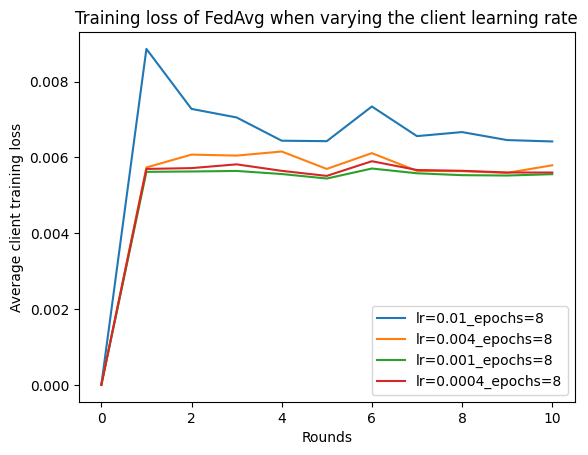

In [43]:
for key in ten_round_hist_fedavg.keys():
  all_hist = ten_round_hist_fedavg[key]
  for hist_fedavg in all_hist:
    lr = hist_fedavg[0]
    local_epochs = hist_fedavg[1]
    history = hist_fedavg[2]
    plot_metric(history, "train_loss", "lr=" + str(lr) + "_epochs=" + str(local_epochs), distributed = True)
# mp = {}

# mp[0.01] = [(1, {'avg': 0.002660029371569787, 'all': [(3, 0.0014626579359173775), (3, 2.4092206634425867e-05), (3, 0.0013416622920582693), (3, 0.0030872177643080554), (3, 0.0017838689188162486), (3, 0.001990085312475761), (3, 0.0034196023674060902), (3, 0.002939854903767506), (3, 0.007579982125510772), (3, 0.002971269888803363)]}), (2, {'avg': 0.0025708046249746986, 'all': [(3, 0.002994255550826589), (3, 6.75548468886215e-05), (3, 0.002774178981781006), (3, 0.002840513363480568), (3, 0.0016264435835182667), (3, 0.000899818764689068), (3, 0.0011527070115941267), (3, 7.05978084927968e-05), (3, 0.005993812965850036), (3, 0.007288163372625907)]}), (3, {'avg': 0.0015922036445772392, 'all': [(3, 0.002283024756858746), (3, 6.020908222126309e-05), (3, 0.0027133108427127204), (3, 0.0003872461032491022), (3, 0.0009404390293639153), (3, 0.0024036182245860496), (3, 0.0017516296938993037), (3, 5.869202019918399e-05), (3, 0.0035825370190044246), (3, 0.0017413296736776829)]}), (4, {'avg': 0.0028483759767065444, 'all': [(3, 0.0015813893017669518), (3, 0.004098587669432163), (3, 0.0030862828716635704), (3, 0.0040502112824469805), (3, 0.0014989420693988602), (3, 0.0013097644550725818), (3, 0.001535139512270689), (3, 0.001908320855970184), (3, 0.0059318095445632935), (3, 0.003483312204480171)]}), (5, {'avg': 0.002575338245939444, 'all': [(3, 0.002006029632563392), (3, 0.006001321133226156), (3, 0.0008540237904526293), (3, 0.00495552954574426), (3, 0.0030776363176604113), (3, 5.808294311767289e-05), (3, 0.0018620080469797056), (3, 0.002975057732934753), (3, 0.00160941524275889), (3, 0.002354278073956569)]}), (6, {'avg': 0.002990446587015564, 'all': [(3, 0.006552140228450298), (3, 0.0037956795810411372), (3, 0.0048065159159402055), (3, 0.0010100359019512932), (3, 0.0015566897733757894), (3, 0.0025046267546713352), (3, 0.004108503228053451), (3, 0.0030713608333220086), (3, 0.001103199921393146), (3, 0.0013957137319569786)]}), (7, {'avg': 0.001989887489313939, 'all': [(3, 0.004136502432326476), (3, 0.000762136303819716), (3, 0.0013448826891059678), (3, 0.0069886562414467335), (3, 0.0007957037208446612), (3, 0.0011099607800133526), (3, 0.0006174578059775134), (3, 0.0011906757523926597), (3, 3.8249034332693554e-05), (3, 0.002914650132879615)]}), (8, {'avg': 0.0017722293614497175, 'all': [(3, 0.002740195719525218), (3, 0.0015148497574652235), (3, 0.002219397846298913), (3, 0.0015787876133496563), (3, 0.0008461862065208455), (3, 6.425330745211492e-05), (3, 0.005087843785683314), (3, 0.0013278152327984571), (3, 6.66548063842735e-05), (3, 0.0022763093390191593)]}), (9, {'avg': 0.0016870564089307056, 'all': [(3, 0.00039054038340206415), (3, 0.000911679002456367), (3, 0.0012471294612623751), (3, 7.119528891053051e-05), (3, 0.003452280846734842), (3, 0.0005957165267318487), (3, 0.0015044733493899305), (3, 0.003259992382178704), (3, 0.0005674626445397735), (3, 0.004870094203700622)]}), (10, {'avg': 0.0019387931330129503, 'all': [(3, 0.0011176714518417914), (3, 0.005773661658167839), (3, 0.001330742457260688), (3, 0.001462205817612509), (3, 0.0017987294898678858), (3, 0.0016031724323208134), (3, 0.001691216214870413), (3, 0.0009904765562775235), (3, 0.002274210642402371), (3, 0.00134584460950767)]})]
# mp[0.004] = [(1, {'avg': 0.002704424017671651, 'all': [(3, 0.003992702191074689), (3, 0.0027967693749815226), (3, 0.0018093970138579607), (3, 0.001905242291589578), (3, 0.0032293377444148064), (3, 0.00536240062986811), (3, 0.0016482756473124027), (3, 0.003811273413399855), (3, 0.00030888142161226523), (3, 0.002179960448605319)]}), (2, {'avg': 0.002158173714512183, 'all': [(3, 0.004732290593286355), (3, 0.00032012350372194004), (3, 0.00023438148006486395), (3, 0.0029861986792335906), (3, 0.0018691227305680513), (3, 0.0028545571646342673), (3, 0.0033722151226053634), (3, 0.0027453385603924594), (3, 0.0013364119998489816), (3, 0.0011310973107659568)]}), (3, {'avg': 0.0019085777736715197, 'all': [(3, 0.00018027269591887793), (3, 0.004281162361924847), (3, 0.00021906072652200237), (3, 0.0031628992098073163), (3, 0.0018624050620322425), (3, 0.000565980066312477), (3, 0.002887583958605925), (3, 0.001276636146940291), (3, 0.002398459861675898), (3, 0.0022513176469753184)]}), (4, {'avg': 0.0029878367417647193, 'all': [(3, 0.0018269328866153955), (3, 0.0022421369406705103), (3, 0.0034935788717120886), (3, 0.006575301910440127), (3, 0.0019161670158306758), (3, 0.0021710682970782122), (3, 0.0037474981509149075), (3, 0.001499318420731773), (3, 0.004669378201166789), (3, 0.0017369867224867146)]}), (5, {'avg': 0.0026312639386257314, 'all': [(3, 0.00020529067114694044), (3, 0.0023951721377670765), (3, 0.000963559199590236), (3, 0.0038119472252825894), (3, 0.0017230070661753416), (3, 0.002456783860300978), (3, 0.003612987231463194), (3, 0.005251568431655566), (3, 0.0024704397656023502), (3, 0.00342188379727304)]}), (6, {'avg': 0.002970825182273984, 'all': [(3, 0.0016151937500884135), (3, 0.001901715761050582), (3, 0.0032806023955345154), (3, 0.005017922725528479), (3, 0.0017286355141550303), (3, 0.00405551609583199), (3, 0.00456132631128033), (3, 0.0035129800283660493), (3, 0.0026519192227472863), (3, 0.0013824400181571643)]}), (7, {'avg': 0.002050955840483463, 'all': [(3, 0.003942280386885007), (3, 0.003581964566061894), (3, 0.000962304805094997), (3, 0.0019367403195550044), (3, 0.004415458844353755), (3, 0.0017711985468243558), (3, 0.0012107097815411787), (3, 0.0002836656494764611), (3, 0.0014687816922863324), (3, 0.0009364538127556443)]}), (8, {'avg': 0.001836718925430129, 'all': [(3, 0.0016824675258249044), (3, 0.004000578463698427), (3, 0.002071225239584843), (3, 0.0018406281402955453), (3, 0.00112207707328101), (3, 0.0031648384562383094), (3, 0.0024273188319057226), (3, 0.0015947745414450765), (3, 0.00017287110191925117), (3, 0.0002904098801082)]}), (9, {'avg': 0.002037278732314007, 'all': [(3, 0.005370626536508401), (3, 0.003535275114700198), (3, 0.000205310852228043), (3, 0.0038383585245658955), (3, 0.00044590090449977043), (3, 0.0020245666382834315), (3, 0.0014821082974473636), (3, 0.0010734817090754707), (3, 0.0016443975813065965), (3, 0.0007527611645249029)]}), (10, {'avg': 0.00230006396304816, 'all': [(3, 0.001934838752883176), (3, 0.0017427649193753798), (3, 0.001973122280711929), (3, 0.0021472931063423553), (3, 0.0052727336684862776), (3, 0.002039831131696701), (3, 0.002011608138370017), (3, 0.0016294231560702126), (3, 0.002954957696298758), (3, 0.0012940667802467942)]})]
# mp[0.001] = [(1, {'avg': 0.004033105476992205, 'all': [(3, 0.0044521923797825975), (3, 0.0033748033456504345), (3, 0.0035410368194182715), (3, 0.0032659193190435567), (3, 0.0009777915159550805), (3, 0.004567100511242946), (3, 0.0055564579864343005), (3, 0.005622321584572394), (3, 0.005631346565981706), (3, 0.0033420847418407598)]}), (2, {'avg': 0.0030581044595843804, 'all': [(3, 0.0030678946835299334), (3, 0.004301233061899741), (3, 0.005889516789466143), (3, 0.004945981626709302), (3, 0.0011704005300998688), (3, 0.003483780970176061), (3, 0.0036262950549523034), (3, 0.0011072562386592228), (3, 0.0019462578929960728), (3, 0.001042427747355153)]}), (3, {'avg': 0.002966627492181336, 'all': [(3, 0.0038454460445791483), (3, 0.0051362185428539915), (3, 0.001406972180120647), (3, 0.0018409327991927664), (3, 0.005382513316969077), (3, 0.003530254432310661), (3, 0.004035701043903828), (3, 0.0010596230858936906), (3, 0.0010537980706430972), (3, 0.002374815405346453)]}), (4, {'avg': 0.004118922833974163, 'all': [(3, 0.004897163870433967), (3, 0.002453539132451018), (3, 0.002332421330114206), (3, 0.004289662931114435), (3, 0.005186607285092275), (3, 0.003936080727726221), (3, 0.0051515235876043635), (3, 0.004270320603003104), (3, 0.0035781690385192633), (3, 0.0050937398336827755)]}), (5, {'avg': 0.0036507111256166053, 'all': [(3, 0.0009326389020619293), (3, 0.0017590434290468693), (3, 0.004830200225114822), (3, 0.0025484292612721524), (3, 0.003520647141461571), (3, 0.004311353589097659), (3, 0.004859279220302899), (3, 0.0026662112213671207), (3, 0.005018649622797966), (3, 0.006060658643643062)]}), (6, {'avg': 0.004002917468703042, 'all': [(3, 0.0056296903640031815), (3, 0.0023626959106574454), (3, 0.004155123295883338), (3, 0.005206863861531019), (3, 0.002372766030021012), (3, 0.004382204885284106), (3, 0.005930668363968532), (3, 0.0025695944981028638), (3, 0.002892501729850968), (3, 0.00452706574772795)]}), (7, {'avg': 0.003123582338836665, 'all': [(3, 0.005190211969117324), (3, 0.0010062811779789627), (3, 0.0038629408615330854), (3, 0.0021010150279228887), (3, 0.0020599691197276115), (3, 0.0018379215616732836), (3, 0.002261730143800378), (3, 0.0056829568929970264), (3, 0.0035427677600334087), (3, 0.003690028873582681)]}), (8, {'avg': 0.002859922754578292, 'all': [(3, 0.001184292312245816), (3, 0.0036693960428237915), (3, 0.002523968849952022), (3, 0.004860635536412398), (3, 0.003941679916655024), (3, 0.0010403276537545025), (3, 0.0022727871934572854), (3, 0.0035335442516952753), (3, 0.0012514685125400622), (3, 0.004321127276246746)]}), (9, {'avg': 0.0030847217383173603, 'all': [(3, 0.0014594002859666944), (3, 0.006137195974588394), (3, 0.005018079342941443), (3, 0.0028242170034597316), (3, 0.001140792582494517), (3, 0.0021128604421392083), (3, 0.0036165406927466393), (3, 0.0016899644397199154), (3, 0.002686522202566266), (3, 0.0041616444165507955)]}), (10, {'avg': 0.0034010612987913193, 'all': [(3, 0.0031342424917966127), (3, 0.002378265645044545), (3, 0.0020988833469649157), (3, 0.002723594894632697), (3, 0.002614223165437579), (3, 0.0034744252916425467), (3, 0.003111461798350016), (3, 0.006125535350292921), (3, 0.003923479622850816), (3, 0.004426501380900542)]})]
# mp[0.0004] = [(1, {'avg': 0.005130278431655218, 'all': [(3, 0.003927292767912149), (3, 0.005869784702857335), (3, 0.006555919535458088), (3, 0.005637809789429109), (3, 0.004405727609992027), (3, 0.0056997441376249), (3, 0.0016785605112090707), (3, 0.005133658957978089), (3, 0.0049121146245549125), (3, 0.007482171679536502)]}), (2, {'avg': 0.00364581336810564, 'all': [(3, 0.004218433517962694), (3, 0.0015295624422530334), (3, 0.006514369820555051), (3, 0.0014320852933451533), (3, 0.004130645111824076), (3, 0.005827785469591618), (3, 0.00239131188330551), (3, 0.004504343494772911), (3, 0.002074587857350707), (3, 0.0038350087900956473)]}), (3, {'avg': 0.004012132870654265, 'all': [(3, 0.0064415827703972655), (3, 0.0013094705063849688), (3, 0.006216746599723895), (3, 0.006169978529214859), (3, 0.0019356747313092153), (3, 0.004474482033401728), (3, 0.0033146393640587726), (3, 0.0033598672598600388), (3, 0.004170844020942847), (3, 0.0027280428912490606)]}), (4, {'avg': 0.004998293922593196, 'all': [(3, 0.00492815828571717), (3, 0.005143461904178063), (3, 0.005559202128400405), (3, 0.0057484252999226255), (3, 0.005947358130166928), (3, 0.0057685890545447665), (3, 0.0024215975621094308), (3, 0.005234635279824336), (3, 0.0036539049663891396), (3, 0.005577606614679098)]}), (5, {'avg': 0.004545744512385378, 'all': [(3, 0.005446524669726689), (3, 0.003359213393802444), (3, 0.0016863773732135694), (3, 0.004322380293160677), (3, 0.00700232091670235), (3, 0.0059423684142529964), (3, 0.0020822352962568402), (3, 0.006322978685299556), (3, 0.006217295459161202), (3, 0.0030757506222774587)]}), (6, {'avg': 0.004798306493709484, 'all': [(3, 0.006109479969988267), (3, 0.005027476853380601), (3, 0.0034977832498649755), (3, 0.0038652928390850625), (3, 0.006763561473538478), (3, 0.002499947945276896), (3, 0.005594494131704171), (3, 0.003203874841953317), (3, 0.00597288195664684), (3, 0.0054482716756562395)]}), (7, {'avg': 0.003987590436978886, 'all': [(3, 0.004059278483813007), (3, 0.00526572298258543), (3, 0.0035598642037560544), (3, 0.0065604280680418015), (3, 0.0023820330388844013), (3, 0.001512875120776395), (3, 0.005326428295423587), (3, 0.0020919160451740026), (3, 0.0035431925983478627), (3, 0.005574165532986323)]}), (8, {'avg': 0.003734390231935928, 'all': [(3, 0.006139712718625863), (3, 0.00420143292285502), (3, 0.0011464360286481678), (3, 0.005782832702000936), (3, 0.0034499050428469977), (3, 0.004756004549562931), (3, 0.005420472472906113), (3, 0.0013609797654983897), (3, 0.0024860056582838297), (3, 0.0026001204581310353)]}), (9, {'avg': 0.004185988137032836, 'all': [(3, 0.005760030510524909), (3, 0.001927772187627852), (3, 0.004505271402498086), (3, 0.00398044940084219), (3, 0.0032241251319646835), (3, 0.004107175162062049), (3, 0.0027318610033641257), (3, 0.005540079747637113), (3, 0.007163568710287412), (3, 0.0029195481135199466)]}), (10, {'avg': 0.004504365175186346, 'all': [(3, 0.004935256050278743), (3, 0.005209037568420172), (3, 0.003127086441963911), (3, 0.007107800338417292), (3, 0.005201957964648803), (3, 0.005928320344537497), (3, 0.002488194848410785), (3, 0.003010303092499574), (3, 0.0038510079806049666), (3, 0.0041846871220817166)]})]
# for key, val in mp.items():
#     n = len(val)

#     avgs = []
#     stds = []
#     for i in range(n):
#       avg_arr = []
#       count = 0
#       for j in val[i][1]['all']:
#         avg_arr.append(j[1])
#       avgs.append(np.mean(avg_arr))
#       stds.append(np.std(avg_arr))
#     x1 = np.arange(len(avgs))
#     line, = plt.plot(x1, avgs, label = "lr=" + str(key) + "_epochs=" + str(8))
#     line_color = line.get_color()
#     # plt.errorbar(x1, avgs, stds, linestyle='None', marker='^', color=line_color, ecolor=line_color)


plt.title("Training loss of FedAvg when varying the client learning rate")
plt.xlabel("Rounds")
plt.ylabel("Average client training loss")
plt.legend()
plt.show()

In [44]:
# Search through hyperparameter values
ten_round_hist_fedavg = {}
ten_round_hist_fedavg[lda_concentration_string[i]] = []
for epoch in [4,8,16]:
  train_config["epochs"] = epoch
  train_config["client_learning_rate"] = 1e-3
  def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
      return train_config | {"server_round": server_round}
  fedavg = FedAvg(
      fraction_fit=fraction_fit,
      fraction_evaluate=fraction_evaluate,
      min_fit_clients=min_fit_clients,
      min_available_clients=min_available_clients,
      on_fit_config_fn=_on_fit_config_fn,
      on_evaluate_config_fn=_on_evaluate_config_fn,
      initial_parameters=initial_parameters,
      accept_failures=accept_failures,
      evaluate_fn=(
              federated_evaluation_function if fed_eval else None
          ),
      fit_metrics_aggregation_fn=aggregate_weighted_average,
      evaluate_metrics_aggregation_fn=aggregate_weighted_average,
  )
  params, hist = start_seeded_simulation(
      client_fn=lambda cid: federated_save_activation_flower_client_generator(cid).to_client(),
      num_clients=num_total_clients,
      config=ServerConfig(num_rounds=num_rounds),
      strategy=fedavg,
      name=f"fedavg_lda_{lda_concentration_string[i]}",
  )
  ten_round_hist_fedavg[lda_concentration_string[i]].append([train_config["client_learning_rate"], epoch, hist])

Streaming output truncated to the last 5000 lines.
 88%|████████▊ | 7/8 [00:26<00:03,  3.55s/it]


100%|██████████| 8/8 [00:30<00:00,  3.78s/it]

100%|██████████| 8/8 [00:31<00:00,  3.91s/it]


100%|██████████| 8/8 [00:29<00:00,  3.75s/it]



100%|██████████| 8/8 [00:30<00:00,  3.75s/it]
DEBUG flwr 2024-03-20 15:32:03,336 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures
100%|██████████| 47/47 [00:00<00:00, 54.20it/s]
INFO flwr 2024-03-20 15:32:04,274 | server_returns_parameters.py:120 | fit progress: (7, 53.593252062797546, {'accuracy': 0.6173333333333333}, 529.4172513180001)
INFO:flwr:fit progress: (7, 53.593252062797546, {'accuracy': 0.6173333333333333}, 529.4172513180001)
DEBUG flwr 2024-03-20 15:32:04,278 | server_returns_parameters.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 100)
DEBUG:flwr:evaluate_round 7: strategy sampled 2 clients (out of 100)
INFO flwr 2024-03-20 15:

lr=0.001_epochs=4_accuracy:  (0.6046666666666667, 0.6113333333333333, 0.6086666666666667, 0.6126666666666667, 0.6106666666666667, 0.6106666666666667, 0.6086666666666667, 0.616, 0.6153333333333333, 0.6133333333333333, 0.616)
lr=0.001_epochs=8_accuracy:  (0.6046666666666667, 0.612, 0.616, 0.6146666666666667, 0.6086666666666667, 0.6173333333333333, 0.6126666666666667, 0.6173333333333333, 0.62, 0.6186666666666667, 0.6173333333333333)
lr=0.001_epochs=16_accuracy:  (0.6046666666666667, 0.6186666666666667, 0.616, 0.62, 0.612, 0.6186666666666667, 0.6126666666666667, 0.6173333333333333, 0.6166666666666667, 0.6173333333333333, 0.612)


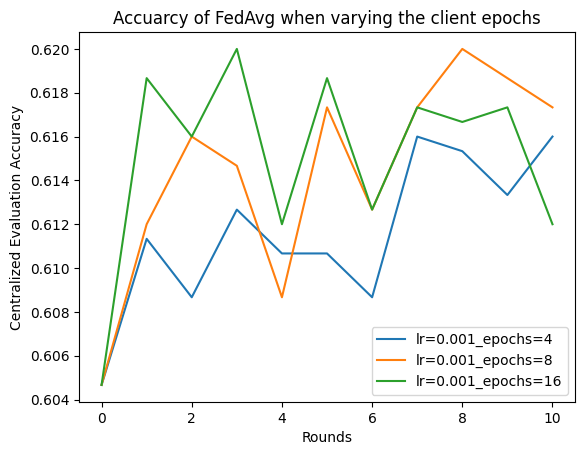

In [48]:
for key in ten_round_hist_fedavg.keys():
  all_hist = ten_round_hist_fedavg[key]
  for hist_fedavg in all_hist:
    lr = hist_fedavg[0]
    local_epochs = hist_fedavg[1]
    history = hist_fedavg[2]
    plot_metric(history, "accuracy", "lr=" + str(lr) + "_epochs=" + str(local_epochs), distributed = False)
plt.title("Accuarcy of FedAvg when varying the client epochs")
plt.xlabel("Rounds")
plt.ylabel("Centralized Evaluation Accuracy")
plt.legend()
plt.show()

In [ ]:
# fifty_round_fedavg_acc = (0.6046666666666667, 0.6093333333333333, 0.61, 0.6146666666666667, 0.6233333333333333, 0.6066666666666667, 0.62, 0.61, 0.6013333333333334, 0.6066666666666667, 0.6226666666666667, 0.612, 0.6113333333333333, 0.62, 0.6133333333333333, 0.6166666666666667, 0.6133333333333333, 0.608, 0.614, 0.6086666666666667, 0.6153333333333333, 0.6006666666666667, 0.6073333333333333, 0.602, 0.6173333333333333, 0.61, 0.6126666666666667, 0.6166666666666667, 0.61, 0.6153333333333333, 0.6133333333333333, 0.6113333333333333, 0.6106666666666667, 0.5986666666666667, 0.61, 0.6133333333333333, 0.606, 0.6186666666666667, 0.618, 0.6226666666666667, 0.61, 0.6213333333333333, 0.612, 0.6093333333333333, 0.618, 0.6146666666666667, 0.6053333333333333, 0.616, 0.6146666666666667, 0.606, 0.6066666666666667)
# fifty_round_fedavg_loss = [0.0, 0.004074649470082173, 0.0031504792471726733, 0.0029561602335888898, 0.003967309432725112, 0.0036267458364212268, 0.00419379345451792, 0.00301720669764715, 0.0029679805632137385, 0.003104511838561545, 0.0035314285079948602, 0.0037418951746076338, 0.003218510853669917, 0.003859101534665873, 0.0032927014826176063, 0.0028896403033286332, 0.002805999388995891, 0.0036448290222324425, 0.004022041797482719, 0.0030893869775657857, 0.00353476974220636, 0.0034207363923390703, 0.0029168152696608255, 0.0032441470733222864, 0.0033815903472714124, 0.003555949680351963, 0.0034331050332790866, 0.0031570271957510458, 0.0037899271391021714, 0.002335722506783592, 0.002829153816370914, 0.0038098102707105376, 0.003869372214345882, 0.0035883672768250107, 0.0030186009137347963, 0.003172778846540798, 0.004023005619334679, 0.00283931009665442, 0.0032059578807093203, 0.003524204778174559, 0.0028442867774477543, 0.002957306602426494, 0.0034492038035144404, 0.002605785210228836, 0.0024309477807643513, 0.0034647083220382528, 0.0028705884508478147, 0.0042633756374319395, 0.0027867645898368206, 0.0033802238564627865, 0.003565604532680785]


lr=0.001_epochs=4_train_loss:  [0.0, 0.005583056807518006, 0.005707940987000863, 0.005815644267325599, 0.0056402332615107294, 0.0055920459485302365, 0.005984811267505089, 0.005762883741408586, 0.005670070384318629, 0.005645029122630755, 0.0055984257099529105]

lr=0.001_epochs=8_train_loss:  [0.0, 0.005614942343284686, 0.005660239607095719, 0.005770701542496681, 0.00559225312123696, 0.005429285128290455, 0.005875077579791347, 0.0055900920027246075, 0.00546701621885101, 0.005428247914339106, 0.005561009918649992]

lr=0.001_epochs=16_train_loss:  [0.0, 0.0054151063629736505, 0.005565144897749026, 0.005605457304045557, 0.0053811994381248954, 0.005314605527867873, 0.005623642743254701, 0.005336434774411221, 0.0052642226452007885, 0.005403162973622481, 0.005310153045381109]


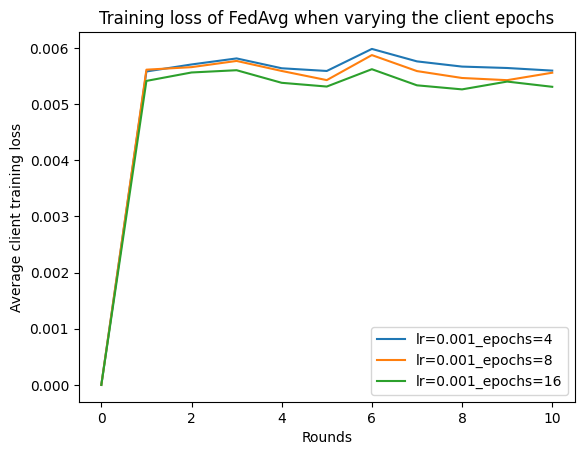

In [47]:
for key in ten_round_hist_fedavg.keys():
  all_hist = ten_round_hist_fedavg[key]
  for hist_fedavg in all_hist:
    lr = hist_fedavg[0]
    local_epochs = hist_fedavg[1]
    history = hist_fedavg[2]
    plot_metric(history, "train_loss", "lr=" + str(lr) + "_epochs=" + str(local_epochs), distributed = True)
plt.title("Training loss of FedAvg when varying the client epochs")
plt.xlabel("Rounds")
plt.ylabel("Average client training loss")
plt.legend()
plt.show()

In [49]:
from flwr.server.strategy import FedAdam, FedYogi

num_rounds = 10

fedadam = FedAdam(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    evaluate_fn=(
            federated_evaluation_function if fed_eval else None
        ),
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    eta = 1,
    eta_l = 1e-1,
    beta_1 = 0.9,
    beta_2 = 0.99,
    tau = 1e-9
)

fedyogi = FedYogi(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    evaluate_fn=(
            federated_evaluation_function if fed_eval else None
        ),
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    eta = 1,
    eta_l = 1e-1,
    beta_1 = 0.9,
    beta_2 = 0.99,
    tau = 1e-9
)

In [ ]:
# Search through hyperparameter values
ten_round_hist_fedadam = {}
ten_round_hist_fedadam[lda_concentration_string[i]] = []
for server_learning_rate in [1e-3, 4e-4, 1e-4]:
  for learning_rate in [1e-3, 4e-3, 1e-4]:

    train_config["epochs"] = 8
    train_config["client_learning_rate"] = learning_rate
    def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
        return train_config | {"server_round": server_round}
    fedadam = FedAdam(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=_on_fit_config_fn,
        on_evaluate_config_fn=_on_evaluate_config_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        evaluate_fn=(
                federated_evaluation_function if fed_eval else None
            ),
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        eta = server_learning_rate,
        eta_l = learning_rate,
        beta_1 = 0.9,
        beta_2 = 0.99,
        tau = 1e-9
    )
    params, hist = start_seeded_simulation(
        client_fn=lambda cid: federated_save_activation_flower_client_generator(cid).to_client(),
        num_clients=num_total_clients,
        config=ServerConfig(num_rounds=num_rounds),
        strategy=fedadam,
        name=f"fedadam_lda_{lda_concentration_string[i]}",
    )
    ten_round_hist_fedadam[lda_concentration_string[i]].append([server_learning_rate, learning_rate, 8, hist])

Streaming output truncated to the last 5000 lines.
 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

 12%|█▎        | 1/8 [00:05<00:40,  5.83s/it]



 12%|█▎        | 1/8 [00:06<00:43,  6.19s/it]




 25%|██▌       | 2/8 [00:12<00:38,  6.34s/it]


 25%|██▌       | 2/8 [00:12<00:38,  6.41s/it]

 25%|██▌       | 2/8 [00:13<00:43,  7.19s/it]



 25%|██▌       | 2/8 [00:13<00:41,  6.98s/it]




 38%|███▊      | 3/8 [00:17<00:29,  5.85s/it]


 38%|███▊      | 3/8 [00:18<00:30,  6.19s/it]

 38%|███▊      | 3/8 [00:19<00:33,  6.65s/it]



 38%|███▊      | 3/8 [00:19<00:32,  6.53s/it]




 50%|█████     | 4/8 [00:23<00:23,  5.81s/it]


 50%|█████     | 4/8 [00:25<00:25,  6.33s/it]

 50%|█████     | 4/8 [00:26<00:26,  6.67s/it]



 50%|█████     | 4/8 [00:26<00:26,  6.70s/it]




 62%|██████▎   | 5/8 [00:29<00:17,  5.90s/it]


 62%|██████▎   | 5/8 [00:30<00:18,  6.09s/it]

 62%|██████▎   | 5/8 [00:32<00:18,  6.29s/it]



 62%|██████▎   | 5/8 [00:32<00:18,  6.32s/it]




 75%|███████▌  | 6/8 [00:36

In [ ]:
for key in ten_round_hist_fedadam.keys():
  all_hist = ten_round_hist_fedadam[key]
  for hist_fedadam in all_hist:
    server_lr = hist_fedadam[0]
    lr = hist_fedadam[1]
    local_epochs = hist_fedadam[2]
    history = hist_fedadam[3]
    plot_metric(history, "accuracy", "server_lr=" + str(server_lr) + "_lr=" + str(lr) + "_epochs=" + str(local_epochs), distributed = False)
plt.title("Accuarcy of FedAdam when varying the server and client learning rates")
plt.xlabel("Rounds")
plt.ylabel("Centralized Evaluation Accuracy")
plt.legend()
plt.show()

In [ ]:
for key in ten_round_hist_fedadam.keys():
  all_hist = ten_round_hist_fedadam[key]
  for hist_fedadam in all_hist:
    server_lr = hist_fedadam[0]
    lr = hist_fedadam[1]
    local_epochs = hist_fedadam[2]
    history = hist_fedadam[3]
    plot_metric(history, "train_loss", "server_lr=" + str(server_lr) + "_lr=" + str(lr) + "_epochs=" + str(local_epochs), distributed = True)
plt.title("Training loss of FedAdam when varying the server and client learning rates")
plt.xlabel("Rounds")
plt.ylabel("Centralized Training loss")
plt.legend()
plt.show()

In [ ]:
# Search through hyperparameter values
ten_round_hist_fedyogi = {}
ten_round_hist_fedyogi[lda_concentration_string[i]] = []
for server_learning_rate in [4e-3, 1e-3, 4e-4]:
  for learning_rate in [4e-3, 1e-3, 4e-4]:

    train_config["epochs"] = 8
    train_config["client_learning_rate"] = learning_rate
    def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
        return train_config | {"server_round": server_round}
    fedyogi = FedYogi(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=_on_fit_config_fn,
        on_evaluate_config_fn=_on_evaluate_config_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        evaluate_fn=(
                federated_evaluation_function if fed_eval else None
            ),
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        eta = server_learning_rate,
        eta_l = learning_rate,
        beta_1 = 0.9,
        beta_2 = 0.99,
        tau = 1e-9
    )
    params, hist = start_seeded_simulation(
        client_fn=lambda cid: federated_save_activation_flower_client_generator(cid).to_client(),
        num_clients=num_total_clients,
        config=ServerConfig(num_rounds=num_rounds),
        strategy=fedyogi,
        name=f"fedyogi_lda_{lda_concentration_string[i]}",
    )
    ten_round_hist_fedyogi[lda_concentration_string[i]].append([server_learning_rate, learning_rate, 8, hist])

In [ ]:
for key in ten_round_hist_fedyogi.keys():
  all_hist = ten_round_hist_fedyogi[key]
  for hist_fedyogi in all_hist:
    server_lr = hist_fedyogi[0]
    lr = hist_fedyogi[1]
    local_epochs = hist_fedyogi[2]
    history = hist_fedyogi[3]
    plot_metric(history, "accuracy", "server_lr=" + str(server_lr) + "_lr=" + str(lr) + "_epochs=" + str(local_epochs), distributed = False)
plt.title("Accuracy of FedYogi when varying the server and client learning rates")
plt.xlabel("Rounds")
plt.ylabel("Centralized Evaluation Accuracy")
plt.legend()
plt.show()

In [ ]:
for key in ten_round_hist_fedyogi.keys():
  all_hist = ten_round_hist_fedyogi[key]
  for hist_fedyogi in all_hist:
    server_lr = hist_fedyogi[0]
    lr = hist_fedyogi[1]
    local_epochs = hist_fedyogi[2]
    history = hist_fedyogi[3]
    plot_metric(history, "train_loss", "server_lr=" + str(server_lr) + "_lr=" + str(lr) + "_epochs=" + str(local_epochs), distributed = True)
plt.title("Training loss of FedYogi when varying the server and client learning rates")
plt.xlabel("Rounds")
plt.ylabel("Average Training Loss")
plt.legend()
plt.show()

In [31]:
optimal_fedavg_lr = 1e-3
optimal_fedavg_epoch = 8

In [32]:
# Search through hyperparameter values
fifty_round_hist_fedavg = {}
num_rounds = 50

for i in range(len(lda_concentrations)):

  train_config["epochs"] = optimal_fedavg_epoch
  train_config["client_learning_rate"] = optimal_fedavg_lr
  def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
      return train_config | {"server_round": server_round}

  save_activation_dir: Path = home_dir / "activation_data"

  save_activation_dir.mkdir(parents=True, exist_ok=True)

  save_activation_rounds = []
  lda_partition: Path = dataset_dir / "client_data_mappings" / "lda" / lda_concentration_string[i]
  lda_activation_data: Path = save_activation_dir / lda_concentration_string[i]
  federated_save_activation_flower_client_generator: Callable[
      [int], FlowerClient
  ] = get_flower_client_generator(
      model_generator=network_generator_cnn,
      partition_dir=lda_partition,
      data_dir=data_dir,
      client_class=FlowerSaveActivationClient,
      save_activation_dir = lda_activation_data,
      save_activation_rounds = save_activation_rounds
  )
  fedavg = FedAvg(
      fraction_fit=fraction_fit,
      fraction_evaluate=fraction_evaluate,
      min_fit_clients=min_fit_clients,
      min_available_clients=min_available_clients,
      on_fit_config_fn=_on_fit_config_fn,
      on_evaluate_config_fn=_on_evaluate_config_fn,
      initial_parameters=initial_parameters,
      accept_failures=accept_failures,
      evaluate_fn=(
              federated_evaluation_function if fed_eval else None
          ),
      fit_metrics_aggregation_fn=aggregate_weighted_average,
      evaluate_metrics_aggregation_fn=aggregate_weighted_average,
  )
  params, hist = start_seeded_simulation(
      client_fn=lambda cid: federated_save_activation_flower_client_generator(cid).to_client(),
      num_clients=num_total_clients,
      config=ServerConfig(num_rounds=num_rounds),
      strategy=fedavg,
      name=f"fedavg_lda_{lda_concentration_string[i]}",
  )
  fifty_round_hist_fedavg[lda_concentration_string[i]] = [params, hist]

Streaming output truncated to the last 5000 lines.
 75%|███████▌  | 3/4 [00:21<00:07,  7.97s/it]



 75%|███████▌  | 3/4 [00:20<00:08,  8.02s/it]




 75%|███████▌  | 3/4 [00:21<00:08,  8.43s/it]


100%|██████████| 4/4 [00:32<00:00,  8.08s/it]
INFO flwr 2024-03-20 13:17:31,102 | <ipython-input-24-26dde4563a2a>:14 | Creating client with cid: 17
INFO:flwr:Creating client with cid: 17
INFO flwr 2024-03-20 13:17:31,103 | <ipython-input-24-26dde4563a2a>:14 | Creating client with cid: 4
INFO:flwr:Creating client with cid: 4

  0%|          | 0/4 [00:00<?, ?it/s]



100%|██████████| 4/4 [00:33<00:00,  9.84s/it]


  0%|          | 0/4 [00:00<?, ?it/s]




INFO flwr 2024-03-20 13:17:34,042 | <ipython-input-24-26dde4563a2a>:14 | Creating client with cid: 64
100%|██████████| 4/4 [00:33<00:00,  8.47s/it]


100%|██████████| 4/4 [00:35<00:00,  8.86s/it]INFO flwr 2024-03-20 13:17:34,426 | <ipython-input-24-26dde4563a2a>:14 | Creating client with cid: 74

100%|██████████| 4/4 [00:34<00:00,  8.55s/it]I

lda=0_1_accuracy:  (0.6046666666666667, 0.614, 0.616, 0.61, 0.6186666666666667, 0.6133333333333333, 0.6153333333333333, 0.6113333333333333, 0.6053333333333333, 0.6113333333333333, 0.622, 0.6146666666666667, 0.614, 0.6186666666666667, 0.6146666666666667, 0.6193333333333333, 0.616, 0.6113333333333333, 0.616, 0.6153333333333333, 0.618, 0.606, 0.6146666666666667, 0.6006666666666667, 0.6173333333333333, 0.614, 0.6186666666666667, 0.616, 0.6146666666666667, 0.622, 0.614, 0.6133333333333333, 0.608, 0.608, 0.6146666666666667, 0.6086666666666667, 0.6153333333333333, 0.6146666666666667, 0.6246666666666667, 0.6193333333333333, 0.6146666666666667, 0.6173333333333333, 0.6173333333333333, 0.6033333333333334, 0.6146666666666667, 0.6153333333333333, 0.6066666666666667, 0.6166666666666667, 0.62, 0.612, 0.6106666666666667)
lda=1_accuracy:  (0.6046666666666667, 0.606, 0.612, 0.6153333333333333, 0.6186666666666667, 0.6126666666666667, 0.6166666666666667, 0.612, 0.6093333333333333, 0.6113333333333333, 0.61

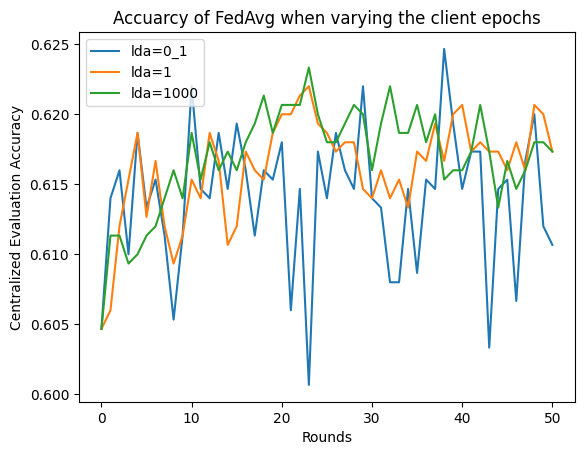

In [33]:
for key in fifty_round_hist_fedavg.keys():
  history = fifty_round_hist_fedavg[key][1]
  plot_metric(history, "accuracy", "lda=" + str(key), distributed = False)
plt.title("Accuarcy of FedAvg when varying the client epochs")
plt.xlabel("Rounds")
plt.ylabel("Centralized Evaluation Accuracy")
plt.legend()
plt.show()


lda=0_1_train_loss:  [0.0, 0.00496193006207856, 0.003771970754799744, 0.003832672592640544, 0.004931264444409558, 0.004402257044178744, 0.004829831312720974, 0.0038813259860035034, 0.0038027258143605047, 0.004042005022832503, 0.004339327224685501, 0.004410796014902492, 0.004005051078274847, 0.004570727981626988, 0.004161720396950841, 0.0035639829662007594, 0.0035774756921455263, 0.004308218311052769, 0.004664143361151219, 0.0035534196300432085, 0.004386942468894024, 0.004547814613518615, 0.0037240870762616394, 0.003959349624346941, 0.003977406009410818, 0.004348826903151348, 0.00402256272888432, 0.003838771566127737, 0.004629314915897945, 0.0029235287957514325, 0.003483175331105789, 0.0044996103815113505, 0.004662963938123236, 0.00418441784568131, 0.003694017499219626, 0.003874551050830633, 0.004763005464337765, 0.003577155705230931, 0.0038575641810894012, 0.004158743866719306, 0.0035708336741663515, 0.0036991970594196268, 0.004195743682794273, 0.0036975055059883743, 0.003149335241566

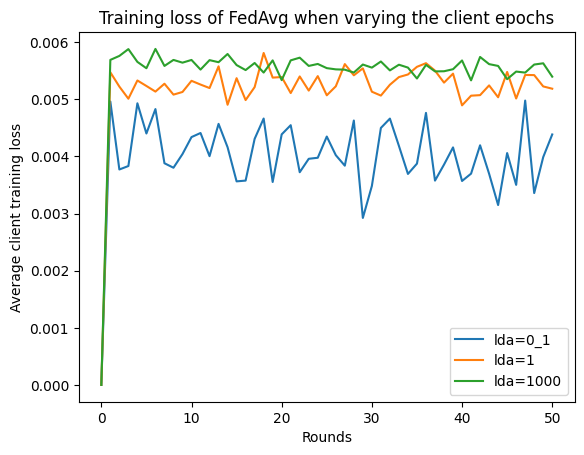

In [36]:
for key in fifty_round_hist_fedavg.keys():
  history = fifty_round_hist_fedavg[key][1]
  plot_metric(history, "train_loss", "lda=" + str(key), distributed = True)
plt.title("Training loss of FedAvg when varying the client epochs")
plt.xlabel("Rounds")
plt.ylabel("Average client training loss")
plt.legend()
plt.show()

In [ ]:
for key in ten_round_hist_fedavg.keys():
  all_hist = ten_round_hist_fedavg[key]
  hist_fedavg = all_hist[0]
  lr = hist_fedavg[0]
  local_epochs = hist_fedavg[1]
  history = hist_fedavg[2]
  plot_metric(history, "accuracy", "lda=" + str(key), distributed = False)
plt.title("Accuarcy of FedAvg when varying the client epochs")
plt.xlabel("Rounds")
plt.ylabel("Centralized Evaluation Accuracy")
plt.legend()
plt.show()

After we found the optimal LR and epochs, we then

Similar to the original FedOpt paper, due to a lack of validation dataset, we use the training loss to assess the performance of a particular set of hyperparameters. In order to see the differences in performance when we vary the different hyperparameters (local epochs, local learning rate) for different LDA concentrations, we first perform a rough grid search using LDA concentration = 0.1 to find the optimal local epoch and local learning rate. This is done using 10 epochs as we want to select a smaller epoch number due to limitations in computing resources, but but we want to assess the average performance (average loss) of the model across several epochs to assess how well the model is being trained. We then vary these hyperparameters individually for each LDA concentration to see how they affect the performance of the model. This approach is less optimal than using hyperparameter tuning over a large search space and over all possible LDA concentrations, but was selected due to limited computation resources. A similar approach is carried out for the other FedOpt variations.

We will then compare it to FedOpt. FedOpt is a general technique involving applying techniques similar to non-SGD optimizers in regular ML to FL, such as Adam, Yogi etc. We first implement them and run similar experiments to above in order to compare the performance of FedAdam and FedYogi against FedAvg. FedAdam and FedYogi involves more tuning parameters compared to FedAvg, and we use the best hyperparameters found in the original FedOpt paper for each algorithm. We still iterate through sets of hyperparametets (learning rate,

In [ ]:
from flwr.server.strategy import FedAdam, FedYogi

fedadam = FedAdam(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    evaluate_fn=(
            federated_evaluation_function if fed_eval else None
        ),
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    eta = 1,
    eta_l = 1e-1,
    beta_1 = 0.9,
    beta_2 = 0.99,
    tau = 1e-9
)

fedyogi = FedYogi(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    evaluate_fn=(
            federated_evaluation_function if fed_eval else None
        ),
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    eta = 1,
    eta_l = 1e-1,
    beta_1 = 0.9,
    beta_2 = 0.99,
    tau = 1e-9
)

In [ ]:
# Search through hyperparameter values
train_config["epochs"] = 1
num_rounds = 100

one_epoch_hist_fedadam = {}
one_epoch_params_fedadam = {}

one_epoch_params_fedadam[lda_concentration_string[i]] = {}
one_epoch_hist_fedadam[lda_concentration_string[i]] = []
for server_learning_rate in [1, 0.1, 0.01]:
    for client_learning_rate in [0.01, 5e-3, 1e-3]:

        train_config["client_learning_rate"] = client_learning_rate
        def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
            return train_config | {"server_round": server_round}
        fedadam = FedAdam(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_available_clients=min_available_clients,
            on_fit_config_fn=_on_fit_config_fn,
            on_evaluate_config_fn=_on_evaluate_config_fn,
            initial_parameters=initial_parameters,
            accept_failures=accept_failures,
            evaluate_fn=(
                    federated_evaluation_function if fed_eval else None
                ),
            fit_metrics_aggregation_fn=aggregate_weighted_average,
            evaluate_metrics_aggregation_fn=aggregate_weighted_average,
            eta = server_learning_rate,
            eta_l = client_learning_rate,
            beta_1 = 0.9,
            beta_2 = 0.99,
            tau = 1e-9
        )
        params, hist = start_seeded_simulation(
            client_fn=lambda cid: federated_save_activation_flower_client_generator(cid).to_client(),
            num_clients=num_total_clients,
            config=ServerConfig(num_rounds=num_rounds),
            strategy=fedadam,
            name=f"fedavg_lda_{lda_concentration_string[i]}",
        )
        one_epoch_params_fedadam[lda_concentration_string[i]].append([server_learning_rate, client_learning_rate, 1, params])
        one_epoch_hist_fedadam[lda_concentration_string[i]].append([server_learning_rate, client_learning_rate, 1, hist])

INFO flwr 2024-03-15 22:00:57,071 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO flwr 2024-03-15 22:00:57,086 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2024-03-15 22:00:57,092 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2024-03-15 22:00:57,097 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 62.21it/s]
INFO flwr 2024-03-15 22:00:57,868 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 55.79068315029144, {'accuracy': 0.6046666666666667}
INFO:flwr:initial parameters (loss, other metrics): 55.79068315029144, {'accuracy': 0.6046666666666667}


In [ ]:
plt.figure(figsize=(10,6))
for key in one_epoch_hist_fedadam.keys():
  all_hist = one_epoch_hist_fedadam[key]
  for hist_fedadam in all_hist:
    server_lr = hist_fedadam[0]
    client_lr = hist_fedadam[1]
    local_epochs = hist_fedadam[2]
    history = hist_fedadam[3]
    plot_metric(history, "accuracy", "server_lr=" + str(server_lr) + "_client_lr=" + str(client_lr), distributed = False)
plt.title("FedAdam 1 local epoch Test Accuracy")
plt.legend()
plt.show()

In [ ]:
for key in one_epoch_hist_fedadam.keys():
  all_hist = one_epoch_hist_fedadam[key]
  for hist_fedadam in all_hist:
    server_lr = hist_fedadam[0]
    client_lr = hist_fedadam[1]
    local_epochs = hist_fedadam[2]
    history = hist_fedadam[3]
    plot_metric(history, "train_loss", "server_lr=" + str(server_lr) + "_client_lr=" + str(client_lr) + "_epochs=" + str(local_epochs), distributed = True)
plt.title("FedAdam 1 local epoch Training Loss")
plt.legend()
plt.show()

In order to evaluate and compare the activations (clients vs clients & clients vs global), an important thing we want to look at is how different these activations are. Since the focus is not the model architecture and its convolutions but rather Federated Learning related properties, we can treat these activations as an indicator of what the model has learnt, since the activations indicate what the model focuses on for each input. Using this idea we can compare sets of activations for different models and retrieve a score on how different the models / models' knowledge are by assessing how different the activations are, using metrics such as average pairwise cosine similarity. This gives us insights into how different aggregation strategies work under different LDA concentrations.

In [ ]:
from numpy.linalg import norm

def cosine_similarity(arr1, arr2):
  return (arr1 @ arr2.T) / (norm(arr1) * norm(arr2))

def compare_activations_pairwise(activations1, activations2, score_fn = cosine_similarity):
  if(isinstance(activations1, dict)):
    output = {}
    for key in activations1.keys():
      activations1_vals = activations1[key]
      activations2_vals = activations2[key]
      count = 0.
      total = 0.
      for act1, act2 in zip(activations1_vals, activations2_vals):
        count += 1
        total += score_fn(activations1_vals, activations2_vals)
      output[key] = count / total
    return output
  else:
    count = 0.
    total = 0.
    for act1, act2 in zip(activations1, activations2):
      count += 1
      total += score_fn(activations1_vals, activations2_vals)

    return count / total


### 2.1 Feature distribution skew


Statisticians and data scientists refer to this property as "covariate shift”. It happens when different clients present samples which describe ideally the same objects having slightly different features. That is the case for two different writers hand-writing the same word, since these may have different stroke widths, slants, etc.
What happens to an FL setting in which this property is strong is not always predictable. Ideally, the global model, obtained using FedAvg, will try to learn a shared representation between clients. This could be problematic since clients have different features to represent their data. We could simply expect that the same seed model trained separately on local clients may perform better than a global model obtained in an FL training.

To see this property in our chosen dataset we will show two images for the same number taken from different clients.
_NOTE: the choice of clients and samples in the following is not random, but suitably made to show you the property._


In [ ]:
client_0_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "0", data_dir=data_dir, name="train"
)
client_1000_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "1000", data_dir=data_dir, name="train"
)
img_a, label_a = client_0_dataset[4]
img_b, label_b = client_1000_dataset[0]

log(INFO, f"For client 0, sample 4 has label {label_a}")
log(INFO, f"For client 1000, sample 0 has label {label_b}")
# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_a)
ax[1].imshow(img_b)

We can also compare the average values of all the features for all the samples of these clients having the label chosen. You can try to execute the cell below choosing different labels.


In [ ]:
label_chosen = 4
features_0 = []
for img, lbl in client_0_dataset:
    if lbl == label_chosen:
        features_0.append(np.asarray(img).flatten())

features_1000 = []
for img, lbl in client_1000_dataset:
    if lbl == label_chosen:
        features_1000.append(np.asarray(img).flatten())

# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow((np.sum(features_0, axis=0) / len(features_0)).reshape((28, 28)))
ax[1].imshow((np.sum(features_1000, axis=0) / len(features_1000)).reshape((28, 28)))

In [ ]:
label_chosen = 1
features_0 = []
for img, lbl in client_0_dataset:
    if lbl == label_chosen:
        features_0.append(np.asarray(img).flatten())

features_1000 = []
for img, lbl in client_1000_dataset:
    if lbl == label_chosen:
        features_1000.append(np.asarray(img).flatten())

# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow((np.sum(features_0, axis=0) / len(features_0)).reshape((28, 28)))
ax[1].imshow((np.sum(features_1000, axis=0) / len(features_1000)).reshape((28, 28)))

It is worth having a glance on what are the consequences of this property on an FL experiment. To do that we will re-use the code for training an FL client from the previous lab.

The following cell is thus meant to import objects and methods you have already used in the previous lab. There's nothing new in the cell below.


In [ ]:
from common.client_utils import (
    to_tensor_transform,
    get_network_generator_mlp,
    get_network_generator_cnn,
    get_model_parameters,
    get_federated_evaluation_function,
    aggregate_weighted_average,
    get_device,
)
from common.client import FlowerClient, get_flower_client_generator

In order to show on a small scale what can happen to FL training setups where clients have feature distribution skew, we will now build two toy settings. We choose the most populated client---the one with the most samples in the federation. We will then construct a second version of this same client by artificially changing its features by inverting the underlying images--- transforming each image into its negative. Furthermore, we need a specific `get_flower_client_generator` able to invert the images of a specific client.

In the following, we provide the relevant methods to do that. These methods are simplified taking advantage of the federation being composed of just two clients.


In [ ]:
def load_FEMNIST_inverted_dataset(mapping: Path, name: str) -> Dataset:
    """Load the filterd FEMNIST dataset given the mapping .csv file.

    The relevant transforms are automatically applied.
    Note that the last transform will invert images, getting their negative
    representation.

    Args:
        mapping (Path): path to the mapping .csv file chosen.
        name (str): name of the dataset to load, train or test.

    Returns
    -------
        Dataset: FEMNIST dataset object, ready to use.
    """
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.functional.invert,
        ]
    )

    return FEMNIST(
        mapping=mapping,
        name=name,
        data_dir=data_dir,
        transform=transform,
        target_transform=to_tensor_transform,
    )


# NOTE: We need the self to use this for replacing an internal of a class


def _load_inverted_dataset(self, name: str) -> Dataset:
    full_file: Path = self.partition_dir / str(self.cid)
    return load_FEMNIST_inverted_dataset(mapping=full_file, name=name)


def get_mod_flower_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerClient]:
    """Wrap the function for the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.
    Note that the "even" clients here will have a modified `_load_dataset` function.
    The new `_load_dataset` has been chosen to be the one inverting the images.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerClient:
        """Create a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            FlowerClient: client instance.
        """
        log(INFO, f"Getting client with id {cid}")
        actual_cid = mapping_fn(int(cid)) if mapping_fn is not None else int(cid)
        client = FlowerClient(
            cid=actual_cid,
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )
        # Pay attention to the following two lines
        if int(cid) % 2 == 0:
            client._load_dataset = _load_inverted_dataset.__get__(client, FlowerClient)
        return client

    return client_fn

We will now try to train separately the two clients generated this way. The mapping function will be provided to point both client IDs to the data of the most populated client.

```python
mapping_dict = {0: '178', 1: '178'}
```

_NOTE: you may want *to experiment \_with \_different\_\_ clients here*. After having completed the lab, feel free to try!_

The following cell will set the relevant configuration for both training and testing of the client and its inverted version.

> **IMPORTANT: The architecture used here is an MLP because it is affected by inversion of images. Also, note that we must seed the model parameters here.**


In [ ]:
# Seed the model
torch.manual_seed(Seeds.DEFAULT)
network_generator_mlp = get_network_generator_mlp()
seed_net_mlp = network_generator_mlp()
seed_model_mlp_params: NDArrays = get_model_parameters(seed_net_mlp)
# Set up config for both train and eval
train_config: dict[str, Any] = {
    "epochs": 8,
    "batch_size": 64,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": None,
}
test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 2,
    "max_batches": None,
}
# Here is the mapping
mapping_dict = {0: "178", 1: "178"}
# NOTE: we are using here the `get_mod_flower_client_generator`
federated_mod_flower_client_generator: Callable[
    [int], FlowerClient
] = get_mod_flower_client_generator(
    model_generator=network_generator_mlp,
    data_dir=data_dir,
    partition_dir=federated_partition,
    mapping_fn=lambda x: mapping_dict[x],
)
# NOTE: we are using here the `get_flower_client_generator`
federated_flower_client_generator: Callable[
    [int], FlowerClient
] = get_flower_client_generator(
    model_generator=network_generator_mlp,
    data_dir=data_dir,
    partition_dir=federated_partition,
    mapping_fn=lambda x: mapping_dict[x],
)

Let's train separately the two versions of the client and then mutually evaluate their models.


In [ ]:
# Create clients
client_0 = federated_mod_flower_client_generator(0)
client_1 = federated_mod_flower_client_generator(1)
# Fit client 0
client_0_params, *rest = fit_client_seeded(
    client_0, seed_model_mlp_params, train_config
)
log(INFO, f"Results of fitting the seed model on client 0:\n\t{rest}")
# Evaluate client 0 on model trained on client 0
client_0_res = client_0.evaluate(client_0_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 0 on the test set of client 0:\n\t%s",
    client_0_res,
)
# Fit client 1
client_1_params, *rest = fit_client_seeded(
    client_1, seed_model_mlp_params, train_config
)
log(INFO, f"Results of fitting the seed model on client 1:\n\t{rest}")
# Evaluate client 1 on model trained on client 1
client_1_res = client_1.evaluate(client_1_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 1 on the test set of client 1:\n\t%s",
    client_1_res,
)
# Evaluate client 0 on model trained on client 0
client_0_res = client_0.evaluate(client_1_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 1 on the test set of client 0:\n\t%s",
    client_0_res,
)
# Evaluate client 1 on model trained on client 1
client_1_res = client_1.evaluate(client_0_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 0 on the test set of client 1:\n\t%s",
    client_1_res,
)

In the following cell, we will set up all the relevant methods and parameters to run an FL simulation.


In [ ]:
def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config.update({"server_round": server_round})


def _on_evaluate_config_fn(server_round: int) -> dict[str, Scalar]:
    return test_config.update({"server_round": server_round})


# NOTE: We don't need the `federated_evaluation_function`. We care about the
# distributed accuracy, thus we skip centralised evaluation.
strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=ndarrays_to_parameters(seed_model_mlp_params),
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

**Question 1 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Using the methods implemented so far, set up two FL settings composed of the clients above. One has both clients with their original dataset, and the other has one client with their features inverted. _(Hint: use `federated_flower_client_generator` for the first setting and `federated_mod_flower_client_generator` for the second setting)_
2. Train the two settings generated at 1) for 5 rounds using `fl.simulation.start_simulation`. Set `num_clients=2` to use only client IDs in `[0,1]`. Use the `strategy` from the cell above.
3. Take note of the evaluation metrics of both FL experiments that you have done. Compare the two using those metrics (plots are recommended). Briefly discuss the results.


### 2.2 Label distribution skew


The flavour of data heterogeneity we are dealing with in this subsection is often called “prior probability shift". In a few words, this occurs when, given a particular label, the distribution of samples having that label differs from client to client. In our running example, we can see whether in FEMNIST happens that different clients have drawn different distributions of symbols.
We can think about what could happen to an FL training in this situation simplifying a bit the actors in a play. Let's imagine that the federation has a subset of clients (one client: client 0) that is the only one having a specific subset of labels (say letters). A global model trained using FedAvg on that federation won't ever be able to learn well the representation of that subset of labels (letters). There exist methods to mitigate this particular situation, but often they involve sharing statistics about local datasets, thus creating privacy concerns.

We will select two clients, then we will plot the histogram of the labels for each of them on the same canvas. Thus, we will be able to evaluate whether there is a qualitative difference between the two.


In [ ]:
client_3000_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "3000", data_dir=data_dir, name="train"
)
plt.hist(
    [int(x[1]) for x in client_0_dataset],
    bins=62,
    color="blue",
    alpha=0.7,
    label="client 0",
)
plt.hist(
    [int(x[1]) for x in client_3000_dataset],
    bins=62,
    color="orange",
    alpha=0.7,
    label="client 3000",
)
plt.legend()

**Question 2 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. If we ignore the privacy assumption of FL and allow the overall label distribution to be known, how could we balance the set of selected clients to guide the federated model towards a similar per-class accuracy that the centralised model can achieve? Assume FedAvg and the usual client implementation in your reasoning.
2. Can you design an automatic data-driven procedure to mitigate label skew? Assume you are operating on a client level, keeping data private, and using standard FedAvg with random client selection.


Question 2

1. If we knew the label distribution, we could simply select clients such that the distribution of labels among the selected clients is similar to the distribution of labels among all the clients, and the model updates averaged from these clients will yield similar per-class accuracy as centralized model due to similar class distributions.

2. We could change the client selection to favour clients that have been selected less for training, for example by only sampling from clients that have not been selected yet, such that the data on each client contributes similarly to the global model.

### 2.3 Quantity skew


The last kind of heterogeneity we will discuss in detail is the _quantity skew_, which occurs when clients possess different numbers of samples. Last, but not least, it is the most investigated property that real FL datasets have. Also called “unbalancedness", it has been tackled using many techniques spanning from data manipulation to optimization algorithm design. Even if the literature regarding such techniques is quite broad, relative to FL being a new topic of research, there is still not any agreement about how to deal with unbalancedness. Often different solutions have different accuracy depending on the task and how unbalanced the FL dataset is.

Those of you that have well-trained observation skills may recall a plot in the last lab that spoiled this property. Now we'll try to get the global view of FEMNIST data from this perspective.


In [ ]:
sns.histplot(
    alpha=0.15,
    legend=True,
    data=[
        len(
            FEMNIST(
                mapping=federated_partition / str(i), data_dir=data_dir, name="train"
            )
        )
        for i in range(3229)
    ],
    fill=True,
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
    common_bins=True,
    cbar=True,
    palette="dark",
)
plt.xlabel("# samples")
plt.show()

**Question 3 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. Given the skewness of number of samples held by each client plotted above, list one potential advantage and one potential disadvantage of training only clients with a number of samples close to the mean (e.g., within one $\sigma$ of the mean).


Question 3

1. One advantage is that this effectively mitigates quantity skewness as all clients used for training have similar number of samples, a disadvantage is that it may amplify other types of skewness such as label distribution skewness as certain clients are never sampled.

# 3. The behaviour of FL under data heterogeneity/creating heterogeneous partitions


## FEMNIST folder structure


By default, FEMNIST will be split as follows:

- `femnist`: the location of the relevant data
  - `client_data_mappings`: contains different partitions
    - `centralized`: mappings from writer_id -> `[image_path, label]` for the centralized dataset
    - `fed_natural`: mappings from writer_id -> `[image_path, label]` for the naturally federated dataset
  - `data`: contains the macro partitions between test, train, and val
    - `train`: contains the raw images---samples of the train set
    - `test`: contains the raw images---samples of the test set
    - `val`: contains the raw images---samples of the val set
- `femnist.tar.gz`: the compressed dataset

We will store client datasets in sequentially labelled folders within each partition and do all necessary remapping in python.


In [ ]:
# Showing resulting folder tree
! tree -dC -L 3 ./

./
├── common
│   └── __pycache__
├── femnist
│   ├── client_data_mappings
│   │   ├── centralized
│   │   └── fed_natural
│   └── data
│       ├── test
│       ├── train
│       └── val
└── sample_data

11 directories


## Test sets for FL


Prior to constructing our centralized partition, it is necessary to discuss what a test set even means for FL.

A testing set can generally be either a **federated test set** or a **local test set**:

- A federated test set contains data representative of the entire federated network and is used to provide a form of centralized-like evaluation of the federated model. In production scenarios, this would be data that has been consensually gathered from a multitude of users and is legal/efficient to store on the server or clients which have been kept out of the training loop. For research purposes it can be constructed in one of the two following ways:
  - Take x% of data from all clients and save it separately.
  - Leave y% of clients utterly unavailable for federated training and use their data as a test/validation set. **This is the version we shall use during the lab for the federated test set.**
- A local test set is formed via data from a specific client which has not been seen during training. There are as many local test sets as there are clients. As such, they can be used to test the model on a specific client or to accumulate average statistics to determine its performance.


## Creating and using partitions


### Class unbalancedness


We will start creating class unbalanced partitions. The most representative example, as often happens, is the extreme one. Thus, we are going to create a partition of the dataset in which each client possesses one class only. This aim sets one parameter for the creation of the current partition, but we need to choose also another parameter: the number of clients we want to create or the number of samples per client that we want to infer. These last are two antagonist parameters that describe the same thing. The larger the number of clients is, the lower the number of samples per client is.

Let's start by looking at how labels are distributed in the entire dataset (test set only), by treating the dataset as centralized.


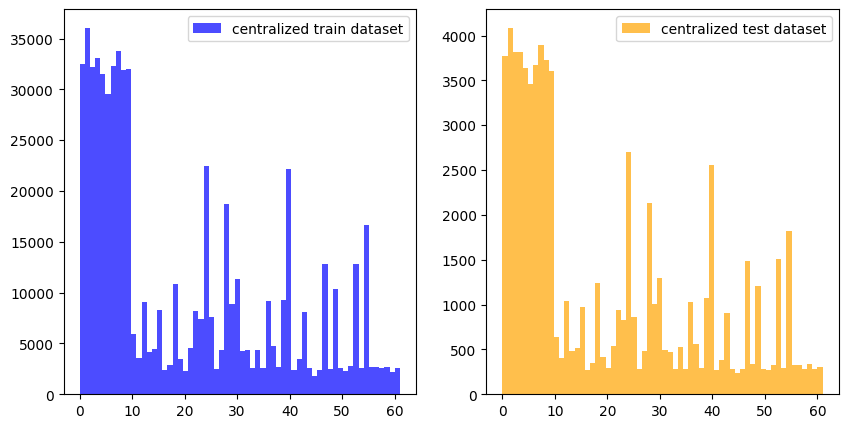

In [ ]:
centralized_train_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition / "0", data_dir=data_dir, name="train"
)
centralized_test_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition / "0", data_dir=data_dir, name="test"
)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_histo = ax[0].hist(
    [int(x[1]) for x in centralized_train_dataset.data],
    bins=62,
    color="blue",
    alpha=0.7,
    label="centralized train dataset",
)
test_histo = ax[1].hist(
    [int(x[1]) for x in centralized_test_dataset.data],
    bins=62,
    color="orange",
    alpha=0.7,
    label="centralized test dataset",
)
ax[0].legend()
ax[1].legend()

Since the distribution is all but uniform, we need to make a further choice. We want to build a federation of 62 clients each of them having one class only. We want all the classes to be represented in the federation. Likewise, we also want FedAvg to treat equally all the clients in the federation. Thus, we will need to partition clients taking into account the population of the least represented class in both the `train` and the `test` set.


In [ ]:
log(
    INFO,
    "The least represented class in the train set has %s samples",
    min(train_histo[0]),
)
log(
    INFO,
    "The least represented class in the test set has %s samples",
    min(test_histo[0]),
)
max_train_samples = int(min(train_histo[0]))
max_test_samples = int(min(test_histo[0]))

INFO flwr 2024-02-10 14:27:02,762 | <ipython-input-38-319cf1b2fc68>:1 | The least represented class in the train set has 1786.0 samples
INFO:flwr:The least represented class in the train set has 1786.0 samples
INFO flwr 2024-02-10 14:27:02,767 | <ipython-input-38-319cf1b2fc68>:6 | The least represented class in the test set has 233.0 samples
INFO:flwr:The least represented class in the test set has 233.0 samples


Let's now create the function that creates the partition. We will stick to the folder structure the dataset has.


In [ ]:
class_unbalanced_partition: Path = (
    dataset_dir / "client_data_mappings" / "class_unbalanced"
)
class_unbalanced_partition.mkdir(parents=True, exist_ok=True)
train_df = pd.read_csv(centralized_mapping / "train.csv")
test_df = pd.read_csv(centralized_mapping / "test.csv")
max_train_samples = 200
max_test_samples = 50
for i in range(62):
    folder_path: Path = class_unbalanced_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    client_df = deepcopy(
        train_df[train_df.label == i].sample(frac=1)[:max_train_samples]
    ).reset_index()
    client_df["client_id"] = i
    client_df.drop(columns=["level_0"], inplace=True)
    client_df.to_csv(train_path, index=False)
    client_df = deepcopy(
        test_df[test_df.label == i].sample(frac=1)[:max_test_samples]
    ).reset_index()
    client_df["client_id"] = i
    client_df.drop(columns=["level_0"], inplace=True)
    client_df.to_csv(test_path, index=False)

Here, we seed the initial model parameters to come from a partially trained model on the centralized dataset.


In [ ]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
centralized_flower_client_generator: Callable[
    [int], FlowerClient
] = get_flower_client_generator(
    model_generator=network_generator_cnn,
    partition_dir=centralized_partition,
    data_dir=data_dir,
)
centralized_flower_client = centralized_flower_client_generator(0)
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": 1000,
}
test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 2,
    "max_batches": None,
}
# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client,
    params=get_model_parameters(seed_net_cnn),
    conf=centralized_train_config,
)
initial_parameters: Parameters = ndarrays_to_parameters(trained_params)

INFO flwr 2024-02-10 14:27:04,471 | client.py:57 | Creating client with cid: 0
INFO:flwr:Creating client with cid: 0


We also create the centralised evaluation function that will be executed by the server at the end of every round if requested.


In [ ]:
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss()
)

INFO flwr 2024-02-10 14:27:30,994 | client_utils.py:388 | Reduced federated test_set size from 28510 to a size of 1500 mean index: 14726.628666666667
INFO:flwr:Reduced federated test_set size from 28510 to a size of 1500 mean index: 14726.628666666667


Finally, the client generator function.


In [ ]:
unbalanced_flower_client_generator: Callable[
    [int], FlowerClient
] = get_flower_client_generator(
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=class_unbalanced_partition,
)

Let's see how these clients look like.


INFO flwr 2024-02-10 14:27:31,015 | client.py:57 | Creating client with cid: 0
INFO:flwr:Creating client with cid: 0
INFO flwr 2024-02-10 14:27:31,107 | client.py:57 | Creating client with cid: 1
INFO:flwr:Creating client with cid: 1


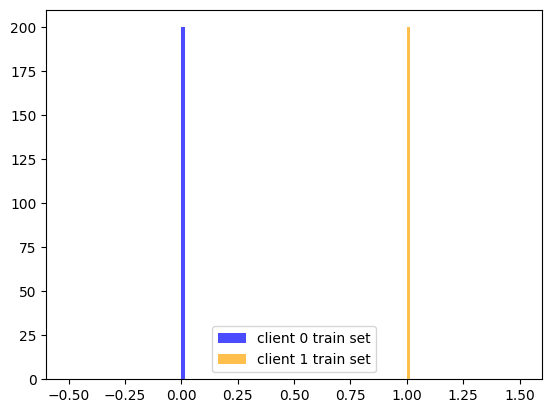

In [ ]:
N_CLASSES = 62
plt.hist(
    [
        int(x[1])
        for x in unbalanced_flower_client_generator(0)._load_dataset("train").data
    ],
    bins=N_CLASSES,
    color="blue",
    alpha=0.7,
    label="client 0 train set",
)
plt.hist(
    [
        int(x[1])
        for x in unbalanced_flower_client_generator(1)._load_dataset("train").data
    ],
    bins=N_CLASSES,
    color="orange",
    alpha=0.7,
    label="client 1 train set",
)
plt.legend()

We will now create a wrapper for the strategy that will be used to extract the clients' model parameters obtained during the training for the next question.


In [ ]:
from flwr.server.client_proxy import ClientProxy
from flwr.common import FitRes, parameters_to_ndarrays


class WrappedFedAvg(FedAvg):
    clients_models: dict[int, list[tuple[int, NDArrays]]] = {}

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[tuple[ClientProxy, FitRes] | BaseException],
    ) -> tuple[Parameters | None, dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        # Call FedAvg original aggregate_fit, so that it handles the failures
        ret = super().aggregate_fit(server_round, results, failures)
        # Append clients' model parameters to the list
        self.clients_models[server_round] = [
            (i, parameters_to_ndarrays(fit_res.parameters))
            for i, (_, fit_res) in enumerate(results)
        ]
        # Return the original return value
        return ret

In [ ]:
train_config: dict[str, Any] = {
    "epochs": 8,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config | {"server_round": server_round}


num_total_clients = 62
num_clients_per_round: int = 5
num_evaluate_clients: int = 5

strategy = WrappedFedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [ ]:
params, hist = start_seeded_simulation(
    client_fn=lambda cid: unbalanced_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=5),
    strategy=strategy,
    name="unbalanced",
)

INFO flwr 2024-02-10 14:27:31,649 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO flwr 2024-02-10 14:27:31,652 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2024-02-10 14:27:31,656 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2024-02-10 14:27:31,666 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:01<00:00, 40.54it/s]
INFO flwr 2024-02-10 14:27:32,848 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 58.245476484298706, {'accuracy': 0.5813333333333334}
INFO:flwr:initial parameters (loss, other metrics): 58.245476484298706, {'accuracy': 0.5813333333333334}
IN

RuntimeError: Simulation crashed.

We will now investigate how such a partition behaves in an FL setting. In particular, we will try to understand what happens to the global model and the clients' updates as the training progresses.


**Question 4 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. For each round, retrieve the clients' models and the global model using the appropriate attribute of the `WrappedFedAvg` strategy.
2. Inspect the models collected for each round as follows:
   - Extract the "softmax-ed" activations of the last layer of each clients' model when the model is fed with random inputs. (HINT: `from common.client_utils import get_activations_from_random_input`, give a motivation for the choice of the parameters of this function if you decide to use it)
   - Compute the pairwise cosine-similarity (you can use functions similar to those used in the previous Lab) between the values obtained in the previous step.
   - Plot the results of this computation in a confusion matrix. The confusion matrix will have the shape `n_clients_per_round`x`n_clients_per_round`.
   - Repeat the same procedure for computing and compare the pairwise KL divergence between the "softmax-ed" activations of the last layer of each clients' model when the model is fed with random inputs. (HINT: `from scipy.stats import entropy`).
3. Compare the confusion matrices obtained. What do you observe, and how does it compare with your expectations? Briefly discuss the results.


**Question 5 (Part III/MPhil ✅):**

(This is meant to be a conceptual question. You should provide a written answer to this. **No more than 3 sentences**. **No code** is needed)

1. How does the concept of a client relate to a task in Multi-task Learning (MTL)?


Question 5

1. If we imagine a task in MTL to be "fitting a model for data on a client", then each client would correspond to a task in MTL, where Federated Learning corresponds to learning to solve multiple of such learning tasks at the same time by exploiting similarities and differences between data across clients.

### LDA partitions


The most popular method for creating heterogeneous partitions from a centralized dataset in terms of class unbalancing is [Latent Dirichlet Allocation (LDA)](https://web.archive.org/web/20120501152722/http://jmlr.csail.mit.edu/papers/v3/blei03a.html). LDA is a generative probabilistic model for collections of discrete data. The paper linked above provides all the theoretical details about the method.

The important detail for you to understand about LDA is that the `concentration` parameter controls the degree of heterogeneity in the distribution while `num_partitions` controls how many clients are generated following the specified distribution.

A `concentration=0` implies a completely heterogeneous distribution where each client may only contain examples from one class. Thus, if for a `concentration=0` we were to set the `num_partitions` argument to the number of classes we will get the same partitioning as the one we manually created above.

> **Important:** The LDA partitioning only approaches a fully i.i.d distribution when `concentration` tends towards $\infty$. The most appropriate value of the `concentration` to generate a completely i.i.d. partition is dataset dependent. Feel free to try out different values of `concentration` and `num_partitions` to see how the partitioning changes.


In [ ]:
from common.lda_utils import create_lda_partitions

Let's create the partitions using LDA with `concentration=2.5` and `num_partitions=1000`. This will result in a non-i.i.d. partitioning.


In [ ]:
N_TOTAL_CLIENTS = 1_000
concentration = 2.5
# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=None,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=concentration,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=dist,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=concentration,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)

Let's store the partitions in the folder structure we have been using so far.


In [ ]:
lda_partition: Path = dataset_dir / "client_data_mappings" / "lda"
if lda_partition.exists():
    ! rm -rf {str(lda_partition)}
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(
    zip(train_clients_partitions, test_clients_partitions, strict=True)
):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame(
        {
            "client_id": [0] * len(train_set[0]),
            "sample_path": train_set[0],
            "sample_id": range(len(train_set[0])),
            "label": train_set[1],
        }
    ).to_csv(train_path, index=False, mode="w")
    pd.DataFrame(
        {
            "client_id": [0] * len(test_set[0]),
            "sample_path": test_set[0],
            "sample_id": range(len(test_set[0])),
            "label": test_set[1],
        }
    ).to_csv(test_path, index=False, mode="w")

We instantiate a client generator function.


In [ ]:
lda_flower_client_generator: Callable[
    [int], FlowerClient
] = get_flower_client_generator(
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=lda_partition,
)

We can also plot two clients' labels distributions to see how different they are.


INFO flwr 2024-02-10 14:31:01,569 | client.py:57 | Creating client with cid: 0
INFO:flwr:Creating client with cid: 0
INFO flwr 2024-02-10 14:31:01,641 | client.py:57 | Creating client with cid: 1
INFO:flwr:Creating client with cid: 1


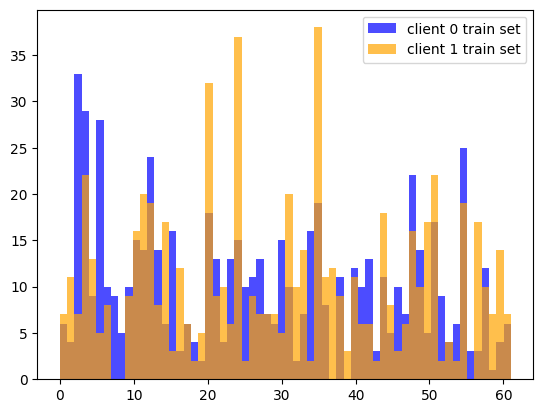

In [ ]:
N_CLASSES = 62
plt.hist(
    [int(x[1]) for x in lda_flower_client_generator(0)._load_dataset("train").data],
    bins=N_CLASSES,
    color="blue",
    alpha=0.7,
    label="client 0 train set",
)
plt.hist(
    [int(x[1]) for x in lda_flower_client_generator(1)._load_dataset("train").data],
    bins=N_CLASSES,
    color="orange",
    alpha=0.7,
    label="client 1 train set",
)
plt.legend()

We try now to run an FL simulation is such challenging setting.


In [ ]:
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config | {"server_round": server_round}


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 5
num_evaluate_clients: int = 0

strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [ ]:
params, hist = start_seeded_simulation(
    client_fn=lambda cid: lda_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=5),
    strategy=strategy,
    name="fedavg_lda_example",
)

INFO flwr 2024-02-10 14:31:02,072 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO flwr 2024-02-10 14:31:02,084 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2024-02-10 14:31:02,089 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2024-02-10 14:31:02,097 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 72.85it/s]
INFO flwr 2024-02-10 14:31:02,762 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 58.245476484298706, {'accuracy': 0.5813333333333334}
INFO:flwr:initial parameters (loss, other metrics): 58.245476484298706, {'accuracy': 0.5813333333333334}
IN

**Question 6 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Produce a set of LDA partitions with `concentration` in `[0.001, 0.1, 1e3]`.
2. Train an FL setting for every partition you have produced using the same hyperparameter we used in the cell above, but with `num_clients_per_round=62` and `ServerConfig(num_rounds=1)`.
3. Why do you think one-shot averaging works well for full i.i.d data and not for very heterogeneous clients?


Use the configuration provided by the following cell.

> **IMPORTANT**: Be careful when using the strategy object. You must ensure that the different experiments will use the same initial parameters. Inspect `flwr.server.strategy.FedAvg` to understand how these are used.


In [ ]:
# NOTE: We are using randomly initialized parameters here.
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
q6_initial_parameters: Parameters = ndarrays_to_parameters(
    get_model_parameters(seed_net_cnn)
)
# Set up experiment configuration
N_TOTAL_CLIENTS = 100
N_TOTAL_ROUNDS = 1
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.001,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config | {"server_round": server_round}


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 62
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
# Set up strategy
strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=q6_initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

# 4. FL Strategies tackling heterogeneity


The challenge of dealing with non-iidness in FL has been discussed extensively since the publication of the first paper about FL. Many approaches have been proposed, but still, the literature doesn't agree on a general approach or a rule of thumb. A natural method is to modify/extend FedAvg or develop another algorithm specifically oriented to mitigating heterogeneity. In some applications, augmenting data to make it more similar between clients is possible. Some works assume a small dataset that is shared between clients to serve as a reference.

Every time a new approach has been proposed, many related questions have arisen. It is no longer clear that treating all examples of all the clients equally make sense. Some works proposed limiting the contributions of data from any client in the federation. The notion of fairness has been introduced and defined in many ways in order to set up principles that could result in new approaches, for example emphasizing underperforming clients during aggregation. It is not even clear whether a single global model is the correct objective for FL---works related to this question gave birth to Personalised Federated Learning (PFL), a sub-branch of research.

We started to think that we should be able to turn the non-iid problem from a bug into a feature treated similarly to a task in MTL. The number of works that start with this perspective is however limited.

Even if FedAvg can partially mitigate heterogeneity, it is not working well in all situations, as we saw previously. From the many new algorithms that were introduced, it is worth mentioning: [FedProx](https://www.researchgate.net/profile/Anit-Sahu/publication/329734586_On_the_Convergence_of_Federated_Optimization_in_Heterogeneous_Networks/links/5c1bdd5e299bf12be38ee52d/On-the-Convergence-of-Federated-Optimization-in-Heterogeneous-Networks.pdf), [q-FedAvg](https://arxiv.org/abs/1905.10497), [SCAFFOLD](http://proceedings.mlr.press/v119/karimireddy20a.html). For a matter of time, we will now explore just one of these algorithms introduced for tackling the non-iid problem specifically. We chose FedProx since it is the simplest to demonstrate.


## FedProx


The Federated Proximal (FedProx) method was developed in the context of tuning and benchmarking FedAvg in a heterogeneous setting. The authors of FedAvg proposed carefully tuning the learning rate and the number of local epochs to increase the accuracy in such settings but turned out clear that something more was necessary. Based on the client's heterogeneity, local updates change the global model not only in different directions in the loss space but also at different rates. This phenomenon is called client divergence or drifting.

Using FedAvg we would like to have a different number of local epochs for each client based on its characteristics. Thus, heuristically setting the number of local updates is not always optimal, because clients are all different from each other. Limiting the number of local updates through a more flexible tool is beneficial. Thus, FedProx proposes to incorporate a term in the local objective function that penalizes big changes from the current model at the server. In each node $k$, instead of minimizing the local loss function $F_k$, the local solver tries to approximately minimize:

$\min_wh_w(w;w^t)=F_k(w)+\frac{\mu}{2}||w-w^t||^2$,

where $||w-w^t||^2$ is the new proximal term.

FedProx acts as FedAvg apart from the change in the local objective. This new objective enforces limited local model updates more explicitly than FedAvg. Using FedProx, it is no longer necessary to tune the number of local epochs for each client to minimize divergence.

We will now implement and test FedProx on the natural partition of FEMNIST. Implementing FedProx just involves modifying the local training function of our `FlowerRayClient`. We will then write the new function and build a new `client_generator` function that overwrites the relevant methods of our client.


In [ ]:
def train_fedprox_FEMNIST(
    net: Module,
    train_loader: DataLoader,
    epochs: int,
    device: str,
    optimizer: torch.optim.Optimizer,
    criterion: Module,
    proximal_mu: float,
) -> float:
    """Trains the network on the training set using FedProx.

    Args:
        net (Module): generic module object describing the network to train.
        train_loader (DataLoader): dataloader to iterate during the training.
        epochs (int): number of epochs of training.
        device (str): device name onto which perform the computation.
        optimizer (torch.optim.Optimizer): optimizer object.
        criterion (Module): generic module describing the loss function.
        proximal_mu (float): parameter for the weight of the proximal term.

    Returns
    -------
        float: the final epoch mean train loss.
    """
    global_params: Module = deepcopy(net)
    global_params.requires_grad_(False)
    global_params = [val for _, val in global_params.state_dict().items()]
    net.train()
    running_loss, total = 0.0, 0
    for _ in tqdm(range(epochs)):
        running_loss = 0.0
        total = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            # NOTE: here comes the implementation of FedProx algorithm
            proximal_term = 0.0
            for local_weights, global_weights in zip(
                net.parameters(), global_params, strict=True
            ):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(data), labels) + (proximal_mu / 2) * proximal_term
            running_loss += loss.item()
            total += labels.size(0)
            loss.backward()
            optimizer.step()
    return running_loss / total


def _train_fedprox(
    self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
) -> float:
    return train_fedprox_FEMNIST(
        net=net,
        train_loader=train_loader,
        epochs=int(config["epochs"]),
        device=self.device,
        optimizer=torch.optim.AdamW(
            net.parameters(),
            lr=float(config["client_learning_rate"]),
            weight_decay=float(config["weight_decay"]),
        ),
        criterion=torch.nn.CrossEntropyLoss(),
        proximal_mu=config["proximal_mu"],
    )


def get_fedprox_flower_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
) -> Callable[[str], FlowerClient]:
    """Implement a wrapper function for the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    The clients generated will train using FedProx algorithm.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.

    Returns
    -------
        Callable[[str], WrappedClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerClient:
        """Create a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            WrappedClient: client instance.
        """
        log(INFO, f"Getting client with id {cid}")
        client = FlowerClient(
            cid=cid,
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )
        # Pay attention to the following line
        client._train = _train_fedprox.__get__(client, FlowerClient)
        return client

    return client_fn

In [ ]:
torch.manual_seed(Seeds.DEFAULT)
N_TOTAL_CLIENTS = 1000
CONCENTRATION = 0.1
# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=None,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=dist,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
)
# Store partitions
lda_partition: Path = dataset_dir / "client_data_mappings" / f"lda_{CONCENTRATION}"
if lda_partition.exists():
    ! rm -rf {str(lda_partition)}
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(
    zip(train_clients_partitions, test_clients_partitions, strict=True)
):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame(
        {
            "client_id": [0] * len(train_set[0]),
            "sample_path": train_set[0],
            "sample_id": range(len(train_set[0])),
            "label": train_set[1],
        }
    ).to_csv(train_path, index=False)
    pd.DataFrame(
        {
            "client_id": [0] * len(test_set[0]),
            "sample_path": test_set[0],
            "sample_id": range(len(test_set[0])),
            "label": test_set[1],
        }
    ).to_csv(test_path, index=False)

We are now able to train an FL setting using FedProx.


In [ ]:
# NOTE: we are using here the `get_fedprox_flower_client_generator`
federated_fedprox_flower_client_generator: Callable[
    [int], FlowerClient
] = get_fedprox_flower_client_generator(
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=lda_partition,
)
N_TOTAL_ROUNDS = 5
# Set up experiment configuration
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.1,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": None,
    "proximal_mu": 0.01,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config | {"server_round": server_round}


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 5
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
# Set up strategy
strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [ ]:
params_list, hist = start_seeded_simulation(
    client_fn=lambda cid: federated_fedprox_flower_client_generator(cid).to_client(),
    num_clients=N_TOTAL_CLIENTS,
    config=ServerConfig(num_rounds=N_TOTAL_ROUNDS),
    strategy=strategy,
    name="fedprox",
)

INFO flwr 2024-02-10 14:42:10,025 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO flwr 2024-02-10 14:42:10,036 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2024-02-10 14:42:10,041 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2024-02-10 14:42:10,045 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 71.62it/s]
INFO flwr 2024-02-10 14:42:10,721 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 58.245476484298706, {'accuracy': 0.5813333333333334}
INFO:flwr:initial parameters (loss, other metrics): 58.245476484298706, {'accuracy': 0.5813333333333334}
IN

**Question 7 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Train the FL setting composed of LDA partitions with `concentration=1.0` using FedProx with values of `proximal_mu` in $\{10.0, 0.1, 1e-5\}$. Keep `num_clients_per_round=5` and `ServerConfig(num_rounds=10)`. Use the experimental configurations bellow.
2. Plot convergence curves for both `proximal_mu`.


In [ ]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
centralized_flower_client_generator: Callable[
    [int], FlowerClient
] = get_flower_client_generator(
    model_generator=network_generator_cnn,
    partition_dir=centralized_partition,
    data_dir=data_dir,
)
centralized_flower_client = centralized_flower_client_generator(0)
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": 1000,
}
# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client,
    params=get_model_parameters(seed_net_cnn),
    conf=centralized_train_config,
)
q7_initial_parameters_pretrained = ndarrays_to_parameters(trained_params)

INFO flwr 2024-02-10 14:42:31,887 | client.py:57 | Creating client with cid: 0
INFO:flwr:Creating client with cid: 0


In [ ]:
N_TOTAL_CLIENTS = 1000
N_TOTAL_ROUNDS = 10
N_CLIENTS_PER_ROUND = 5
CONCENTRATION = 1.0
# Set up experiment configuration
train_config: dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": None,
    # NOTE: This must be adjusted according to the requests
    "proximal_mu": ...,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config | {"server_round": server_round}


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = N_CLIENTS_PER_ROUND
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
# Set up strategy
strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=q7_initial_parameters_pretrained,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=None,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=dist,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
)
# Store partitions
lda_partition: Path = dataset_dir / "client_data_mappings" / f"lda_{CONCENTRATION}"
if lda_partition.exists():
    ! rm -rf {lda_partition}
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(
    zip(train_clients_partitions, test_clients_partitions, strict=True)
):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame(
        {
            "client_id": [0] * len(train_set[0]),
            "sample_path": train_set[0],
            "sample_id": range(len(train_set[0])),
            "label": train_set[1],
        }
    ).to_csv(train_path, index=False)
    pd.DataFrame(
        {
            "client_id": [0] * len(test_set[0]),
            "sample_path": test_set[0],
            "sample_id": range(len(test_set[0])),
            "label": test_set[1],
        }
    ).to_csv(test_path, index=False)
# Create the client generator
fedprox_flower_client_generator: Callable[
    [int], FlowerClient
] = get_fedprox_flower_client_generator(
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=lda_partition,
)

**Question 8 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. No code is needed)

In FL, fairness is generally defined as the variance of the accuracy of the global model on local clients' test sets. If two models have the same average accuracy, the one with the lower variance between clients is the fairer.

- In light of this, is it reasonable to say that analysing the fairness of the model across clients, i.e. the distributed accuracy, could be used as a tool to measure the data heterogeneity? Motivate your answer.
- Both FedAvg and FedProx are training a single global model, so we will always measure some unfairness. Do you think we could improve fairness by finetuning the global model on the local clients just before evaluating it on their local test set?


Question 8

1. Fairness of the same model across different sets of clients could be used as a metric to compare the degree of data heterogeneity, however simply using the fairness of one model across clients may not always be an accurate measure of data heterogeneity as a lot of other factors could affect it, such as the generalizability of the model, the specific model architecture etc.

2. I think in most cases this would improve accuracy, as finetuning the model on the local client dataset would make it perfom better on local client data, and assuming the local training data has similar distribution to local test set this would improve accuracy. This should also improve fairness as if a client's data distribution is very different from global data distribution and it has low accuracy, then this would increase its accuracy more compared to clients with data distributions similar to the global distribution, and thus even out the accuracies.

(c) 2024 Alexandru-Andrei Iacob, Lorenzo Sani
